In [90]:
import os 
import sys
from tqdm import tqdm
import importlib
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from datetime import datetime


module_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"
data_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/data/long_seqs_v11/"
model_save_dir = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11'

if module_path not in sys.path:
    sys.path.append(module_path)

In [8]:
BATCH_SIZE = 256
N_DATA = 4000
T = 20
VOCAB = ['start', 'view', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
EMB_DIM = 16
HIDDEN_DIM = 128

## Load Data

In [9]:
pos_data_path = os.path.join(data_path, 'positive_long_sequences.pickle')
# neg_data_path = os.path.join(data_path, 'negative_long_sequences.pickle')

def load_sequence_from_pickle_to_numpy(pickle_file_path, use_init_token=False):
    """
        A list of sequence in format of (event_type, time_delta)
    :param pickle_file_path: e.g. /.../project-basileus/seq-gan/data/fixed_length/valid_sequences.pickle
    :return: (event_type_seqs, time_delta)
    """
    with open(pickle_file_path, 'rb') as f:
        raw_seqs = pickle.load(f)

    if not raw_seqs or not raw_seqs[0]:
        return np.array([]), np.array([])

    N = len(raw_seqs)
    T = len(raw_seqs[0])
    
    seqs = np.array(raw_seqs)
        
    et_seqs = seqs[:, :, 0].astype(np.float64).reshape((N, T, 1))
    ts_seqs = seqs[:, :, 1].astype(np.float64).reshape((N, T, 1))
    
    return et_seqs, ts_seqs

raw_pos_event_type_seqs, raw_pos_timestamp_seqs = load_sequence_from_pickle_to_numpy(pos_data_path, use_init_token=False)

In [10]:
# cast indicator data into one-hot
pos_event_type_seqs = tf.cast(raw_pos_event_type_seqs, tf.int32)
pos_event_type_seqs = tf.one_hot(pos_event_type_seqs, depth=EVENT_VOCAB_DIM, axis=2, dtype=tf.float64)
pos_event_type_seqs = tf.squeeze(pos_event_type_seqs, axis=3)

In [11]:
def zcore_norm(data):
    N = data.shape[0]
    
    _mean = tf.reduce_mean(data, axis=0)
    _mean = tf.expand_dims(_mean, axis=0)
    _mean = tf.repeat(_mean, N, axis=0)

    _std = tf.math.reduce_std(data, axis=0)
    _std = tf.expand_dims(_std, axis=0)
    _std = tf.repeat(_std, N, axis=0)

    return (data - _mean) / _std, _mean[0,:,:], _std[0,:,:]

def get_mean_std(data):
    _mean = tf.reduce_mean(data, axis=0)
    _mean = tf.expand_dims(_mean, axis=0)

    _std = tf.math.reduce_std(data, axis=0)
    _std = tf.expand_dims(_std, axis=0)

    return _mean, _std

def apply_mean_std(data, _mean, _std):
    N = data.shape[0]
    
    _mean = tf.reshape(_mean, (1, T, 1))
    _mean = tf.repeat(_mean, N, axis=0)
    
    _std = tf.reshape(_std, (1, T, 1))
    _std = tf.repeat(_std, N, axis=0)
    
    return data * _std + _mean

pos_timestamp_seqs, GLOBAL_MEAN, GLOBAL_STD = zcore_norm(raw_pos_timestamp_seqs)

## Global Functions

In [12]:
def create_dataset(features: np.array, labels: np.array, batch_size=2, epochs=10, buffer_size=10000):
    """
    Create dataset from numpy arrays
    """
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

In [43]:
def generate_initial_noise(max_token=EVENT_VOCAB_DIM, time_mean=0, time_std=1, zero_time_start=True):
    init_token_noise_index = tf.random.uniform(shape=[BATCH_SIZE, 1, 1], maxval=max_token, dtype=tf.int32)
    init_token_noise = tf.squeeze(tf.one_hot(init_token_noise_index, EVENT_VOCAB_DIM, axis=2, dtype=tf.float64), axis=3)
        
    if zero_time_start:
        init_time_noise = tf.zeros([BATCH_SIZE, 1, 1], dtype=tf.float64)           
    else:
        init_time_noise = tf.random.truncated_normal(shape=[BATCH_SIZE, 1, 1], mean=time_mean, stddev=time_std, dtype=tf.float64)
        
    return init_token_noise, init_time_noise

In [44]:
from scipy.linalg import sqrtm

def calculate_FID_batch(batch1, batch2, weight=1, N=4000, T=20):
    batch1, batch2 = np.array(batch1).reshape((N, T)), np.array(batch2).reshape((N, T))
    mu1, sigma1 = batch1.mean(axis=0), np.cov(batch1, rowvar=False)
    mu2, sigma2 = batch2.mean(axis=0), np.cov(batch2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid2 = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid2

calculate_FID_score = lambda batch: calculate_FID_batch(raw_pos_timestamp_seqs, batch)
# calculate_FID_score(raw_pos_timestamp_seqs)

In [45]:
class MAD:
    """ Sum square of one-hot distance between tokens
    Params:
    -- batch1         : The first batch of sequences to be compared with the second one
                        or it can be the comparison base
    -- batch2
    Returns:
    --   : dict, sum square of distances and base medians
    """

    def __init__(self):
        self.base_ssad = []
        self.base_med = []
        self.base_med_oh = []
        self.one_hot_map = {0: [1, 0, 0, 0],
                            1: [0, 1, 0, 0],
                            2: [0, 0, 1, 0],
                            3: [0, 0, 0, 1]}

    def nan_if(self, arr, value):
        return np.where(arr == value, np.nan, arr)

    def fit(self, batch1):
        assert len(batch1) > 1, 'batch1 should have more than one sequence'
        X_tok = []
        for i in batch1:
            X_tok.append([j[0] for j in i])
        X_tok_t = np.array(X_tok).T
        X_tok_oh = [[self.one_hot_map[j] for j in i] for i in X_tok]
        medians = [int(i) for i in np.nanmedian(self.nan_if(X_tok_t, 0), axis=1)]
        medians_oh = [self.one_hot_map[j] for j in medians]
        self.base_med = medians
        self.base_med_oh = medians_oh
        tok_dist = []
        for tok in X_tok_oh:
            dist = []
            for j in range(len(tok)):
                tt = np.array(tok[j])
                med = np.array(medians_oh[j])
                # skip 0
                dist.append(np.nansum(np.abs(self.nan_if(tt, 0) - med)))
            tok_dist.append(dist)
        self.base_ssad = np.mean(tok_dist)

    def compare(self, batch2):
        assert len(batch2) > 1, 'batch2 should have more than one sequence'
        X_tok = []
        for i in batch2:
            X_tok.append([j[0] for j in i])
        X_tok_t = np.array(X_tok).T
        X_tok_oh = [[self.one_hot_map[j] for j in i] for i in X_tok]
        medians = [int(i) for i in np.nanmedian(self.nan_if(X_tok_t, 0), axis=1)]
        medians_oh = [self.one_hot_map[j] for j in medians]
        tok_dist = []
        for tok in X_tok_oh:
            dist = []
            for j in range(len(tok)):
                tt = np.array(tok[j])
                med = np.array(self.base_med_oh[j])
                # skip 0
                dist.append(np.nansum(np.abs(self.nan_if(tt, 0) - med)))
            tok_dist.append(dist)
        compare_ssd = np.mean(tok_dist)
        return {'mad': compare_ssd,
                'base_medians': np.array(self.base_med),
                'base_medians_oh': np.array(self.base_med_oh),
                'comp_medians': np.array(medians),
                'comp_medians_oh': np.array(medians_oh)}
    
mad_obj = MAD()
mad_obj.fit(raw_pos_event_type_seqs)
calculate_MAD_score = lambda batch: mad_obj.compare(batch)['mad']
# calculate_MAD_score(raw_pos_event_type_seqs)

def calculate_self_MAD_score(batch):
    self_mad_obj = MAD()
    self_mad_obj.fit(batch)
    return self_mad_obj.compare(batch)['mad']

In [46]:
raw_pos_event_type_seqs.shape

(4000, 20, 1)

In [47]:
# _gen_seqs_et, _gen_seqs_ts = generate_sequences_gumbel(N_DATA, G0, BATCH_SIZE, T)

# # convert one-hot event types to indices; convert normalized timestamps to original
# _gen_seqs_et_ind = tf.argmax(_gen_seqs_et, axis=2).numpy().reshape(N_DATA, T, 1)
# _gen_seqs_ts_ori = apply_mean_std(_gen_seqs_ts, GLOBAL_MEAN, GLOBAL_STD)
# _gen_seqs_for_rules = np.dstack((_gen_seqs_et_ind, _gen_seqs_ts_ori))    

In [48]:
# mad_obj_1 = MAD()
# mad_obj_1.fit(raw_pos_event_type_seqs)

# batch_0 = _gen_seqs_et_ind
# mad_obj_2 = MAD()
# mad_obj_2.fit(_gen_seqs_et_ind)

# print(mad_obj_1.compare(batch_0)['mad'])
# print(mad_obj_2.compare(batch_0)['mad'])
# print(calculate_MAD_score(batch_0))
# print(calculate_self_MAD_score(batch_0))

In [49]:
EVENT_TYPES = ['A', 'B', 'C', 'D']
EVENT_ENCODE = {'A':0, 'B':1, 'C':2, 'D':3}

MIN_SAME_DELAY = 20
MAX_PAIR_DELAY = 200


def check_min_delay_rule(seq, use_init_token=False):
    if use_init_token:
        seq = seq[1:]
    prev_et, _ = None, 0.0
    for et, dt in seq:
        if et == prev_et and dt < MIN_SAME_DELAY:
            return False
        prev_et = et
    return True

def check_paring_rule(seq, use_init_token=False):
    if use_init_token:
        seq = seq[1:]    
    # one-pass: add D to queue to be attributed to the first available C in a reversed linear scanning
    queue = []
    for i in range(len(seq)-1, -1, -1):
        if seq[i][0] == EVENT_ENCODE['D']: # encounter a D event
            queue.append(i)
        elif seq[i][0] == EVENT_ENCODE['C'] and queue: # encounter a C event
            queue.pop(0)
    return len(queue) == 0

def check_max_delay_rule(seq, use_init_token=False):    
    if use_init_token:
        seq = seq[1:]    
        
    def recover_timedelta_to_timestamp(time_seq):
        csum = []
        curr = 0
        for dt in time_seq:
            if dt != 0:
                curr += dt
                csum.append(curr)
            else:
                csum.append(0)
        return csum
    
    ets = [e[0] for e in seq]
    tss = recover_timedelta_to_timestamp([e[1] for e in seq])
        
    # one-pass: add D to queue to be attributed to the first available C in a reversed linear scanning
    queue = []
    for i in range(len(seq)-1, -1, -1):
        if ets[i] == EVENT_ENCODE['D']: # encounter a D event
            queue.append(i)
        elif ets[i] == EVENT_ENCODE['C'] and queue: # encounter a C event
            if tss[queue[0]] - tss[i] <= MAX_PAIR_DELAY:
                queue.pop(0)
            else:
                return False
    # for rule 6, it's fine if there are unpaired D in queue
    # b/c this rules is to ensure for each paired (C, D), the delay is bounded
    return True


def calculate_rule_score(batch):
    N_batch = batch.shape[0]
    cnt = 0
    for i in range(N_batch):
        seq = batch[i, :, :]
        if check_min_delay_rule(seq) and check_paring_rule(seq) and check_max_delay_rule(seq):
            cnt += 1    
    return cnt / N_batch

# calculate_rule_score(batch)

In [50]:
# G0 = build_G(
#     batch_size = BATCH_SIZE,
#     event_vocab_dim = EVENT_VOCAB_DIM,
#     emb_dim = EMB_DIM,
#     hidden_dim= HIDDEN_DIM,
# )
# seqs_random_et, seqs_random_ts = generate_sequences_gumbel(4000, G0, BATCH_SIZE, T)

# seqs_random_et_ind = tf.argmax(seqs_random_et, axis=2).numpy().reshape((N_DATA, T, 1))
# seqs_random_ts_ori = apply_mean_std(seqs_random_ts, GLOBAL_MEAN, GLOBAL_STD)

# batch_for_rules = np.dstack((seqs_random_et_ind, seqs_random_ts_ori))

In [51]:
# _fid_score = calculate_FID_score( seqs_random_ts_ori)
# _mad_score = calculate_MAD_score(seqs_random_et_ind)
# _rule_score = calculate_rule_score(batch_for_rules)

# _fid_score, _mad_score, _rule_score 
# # (10892.375979306666, 0.5591, 0.09175)

## Create multitype SeqGan

In [52]:
# import tensorflow as tf
# from tensorflow.keras import backend as K
# from tensorflow.keras.models import Model
# from tensorflow.keras import Sequential
# from tensorflow.keras.optimizers import Adam, SGD
# from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Activation, Multiply, Add, Lambda
# from tensorflow.keras import regularizers

# from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

# tf.keras.backend.set_floatx('float64')

def build_G(batch_size, event_vocab_dim, emb_dim, hidden_dim=16):
    # inputs of Time-LSTM:
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp

    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)

    hm = LSTM(hidden_dim,
          name='lstm_token',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)

    
    tm = LSTM(hidden_dim,
          name='lstm_time',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
    
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dense_combined = Dense(hidden_dim, 
                           activation='elu',
                           name='dense_combination')(token_time_comb)
        
    token_logits = Dense(event_vocab_dim,
                   activation='linear',
                   name='dense_token',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
        
    time_delta_out = Dense(1,
                   activation='linear',
                   name='dense_time',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
    
    generator = Model(
        inputs=[i_et, i_ts],
        outputs=[token_logits, time_delta_out])
        
    return generator

In [53]:
def build_D(batch_size, T, event_vocab_dim, emb_dim, hidden_dim, dropout_rate=0.25):
    # normal LSTM
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    
    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)
    
    hm = LSTM(hidden_dim,
          name='lstm_token',
          stateful=False, # stateless, never input a partial sequnce for D
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)

    tm = LSTM(hidden_dim,
          name='lstm_time',
          stateful=False, # stateless, never input a partial sequnce for D
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dropped = Dropout(rate=dropout_rate)(token_time_comb)
    
    prob = Dense(1, 
             activation='sigmoid',
             name='final',
             kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
             bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)
        
    discriminator = Model(
        inputs=[i_et, i_ts],
        outputs=prob)
    return discriminator

In [54]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Activation, Multiply, Add, Lambda
from tensorflow.keras import regularizers

from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

tf.keras.backend.set_floatx('float64')

def build_G(batch_size, event_vocab_dim, emb_dim, hidden_dim=16):
    # inputs of Time-LSTM:
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp

    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)
    
    hm, tm = TimeLSTM1(hidden_dim,
                       name='time_lstm',
                       stateful=True, 
                       return_sequences=False,
                       kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                       recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                       time_kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                       bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)    
        
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dense_combined = Dense(hidden_dim, 
                           activation='elu',
                           name='dense_combination')(token_time_comb)
        
    token_logits = Dense(event_vocab_dim,
                   activation='linear',
                   name='dense_token',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
        
    time_delta_out = Dense(1,
                   activation='linear',
                   name='dense_time',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
    
    generator = Model(
        inputs=[i_et, i_ts],
        outputs=[token_logits, time_delta_out])
        
    return generator

In [55]:
def build_D(batch_size, T, event_vocab_dim, emb_dim, hidden_dim, dropout_rate=0.25):
    # normal LSTM
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    
    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)
    
    hm, tm = TimeLSTM1(hidden_dim,
                       name='time_lstm',
                       stateful=True, 
                       return_sequences=False,
                       kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                       recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                       time_kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                       bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dropped = Dropout(rate=dropout_rate)(token_time_comb)
    
    prob = Dense(1, 
             activation='sigmoid',
             name='final',
             kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
             bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)
        
    discriminator = Model(
        inputs=[i_et, i_ts],
        outputs=prob)
    return discriminator

## Define rollout and sequence generation

In [56]:
def sample_gumbel(shape, eps=1e-20): 
    U = tf.random.uniform(shape,minval=0,maxval=1)   #gumbel noise
#     print('noise:{}'.format(U))
    return -tf.math.log(-tf.math.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature=0.5): 
    y = logits + tf.cast(sample_gumbel(tf.shape(logits)), logits.dtype)
    return tf.nn.softmax( y / temperature)  # use softmax to approximate argmax

def gumbel_softmax(logits, temperature=0.5, hard=True):
    """Sample from the Gumbel-Softmax distribution and optionally discretize.
    Args:
    logits: [batch_size, n_class] unnormalized log-probs
    temperature: non-negative scalar
    hard: if True, take argmax, but differentiate w.r.t. soft sample y
    Returns:
    [batch_size, n_class] sample from the Gumbel-Softmax distribution.
    If hard=True, then the returned sample will be one-hot, otherwise it will
    be a probabilitiy distribution that sums to 1 across classes
    """
    logits = tf.cast(logits, tf.float64)
    y = gumbel_softmax_sample(logits, temperature) # this is differentiable
    if hard:
        k = tf.shape(logits)[-1]
        #y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
        y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keepdims=True)),y.dtype)
        y = tf.stop_gradient(y_hard - y) + y
    return y


In [147]:
def rollout_from_initial_gumbel(G, batch_size, init_et, init_ts, L=T):
    # Begin from dummy init state (init_token=1, init_timestamp=0.0)
    all_state_et = init_et
    all_state_ts = init_ts
    
    l_prefix = init_et.shape[1]
    
    G.reset_states()
    # LSTM-token
#     G.layers[4].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
#     G.layers[4].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
#     # LSTM-time
#     G.layers[5].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
#     G.layers[5].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
    
    # Time-LSTM
    G.layers[4].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
    G.layers[4].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))

    for _ in range(L + 1 - l_prefix):  # sequence length
        curr_state_et = all_state_et[:, -1:, :]
        curr_state_ts = all_state_ts[:, -1:, :]
        
        # add step noise to token and time inputs
#         curr_state_et = tf.cast(tf.where(curr_state_et == 1, 0.9, 0.1/3), tf.float64)
#         curr_state_ts = curr_state_ts + tf.random.normal(shape=tf.shape(curr_state_ts), mean=0.0, stddev=1, dtype=tf.float64)

        token_logits, time_delta_out = G([curr_state_et, curr_state_ts])
        
        # sample event types using Gumbel-softmax
        sampled_et = gumbel_softmax(token_logits, temperature=0.9)  # this is differentiable
        sampled_et = tf.reshape(sampled_et, [batch_size, 1, EVENT_VOCAB_DIM])        
        sampled_et = tf.cast(sampled_et, dtype=tf.float64) # cast sampled_et into float
        
        time_delta_out = tf.reshape(time_delta_out, [batch_size, 1, 1]) 
        
        # Do NOT stop genererating once hit end_token; G is supposed to learn it.
        all_state_et = tf.concat([all_state_et, sampled_et], axis=1)
        all_state_ts = tf.concat([all_state_ts, time_delta_out], axis=1)

    # the initlal random states are excluded in output
    return all_state_et[:, 1:, :], all_state_ts[:, 1:, :]


def generate_sequences_gumbel(N_gen, generator, batch_size, T):
    """
        Generate sequences batch per batch
    :param N_gen: total number of seqs to be generated
    :param generator:
    :param batch_size:
    :param T:
    :return: a python list of shape [N_gen, T, 1]
    """
    N = 0
    all_type_seq = None
    all_time_seq = None
    
    init_token_noise, init_time_noise = generate_initial_noise(zero_time_start=True)
        
    while N < N_gen:
        batch_state_et, batch_state_ts = rollout_from_initial_gumbel(generator, batch_size, init_token_noise, init_time_noise, T)

        if all_type_seq is None or all_time_seq is None:
            all_type_seq = batch_state_et
            all_time_seq = batch_state_ts
        else:
            all_type_seq = tf.concat([all_type_seq, batch_state_et], axis=0)
            all_time_seq = tf.concat([all_time_seq, batch_state_ts], axis=0)

        N += batch_size

    all_type_seq = all_type_seq[:N_gen, :, :]
    all_time_seq = all_time_seq[:N_gen, :, :]

    return all_type_seq, all_time_seq

## Pre-Training of Gumbel-Softmax SeqGan

In [148]:
def pretrain_discriminator(event_type_batch, time_delta_batch, label_batch, discriminator, verbose=False, optimizer=Adam(lr=0.001)):
    # train the discriminator
    with tf.GradientTape() as tape:
        # train discriminator
        true_prob = discriminator([event_type_batch, time_delta_batch])

        # cross-entropy loss
        discriminator_loss = ce_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(label_batch, true_prob, from_logits=False)
        )

        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss


def pretrain_generator(event_type_batch, time_delta_batch, generator, verbose=False, optimizer=Adam(lr=0.001)):
    _, T, _ = event_type_batch.shape
    
    # train the generator
    with tf.GradientTape() as tape:
        generator.reset_states()
        step_token_ce_loss_list = []
        step_time_mxe_loss_list = []

        for i in range(0, T - 1):
            curr_state_et = event_type_batch[:, i:i + 1, :]
            curr_state_ts = time_delta_batch[:, i:i + 1, :]
            
            target_et = event_type_batch[:, i + 1, :]
            target_ts = time_delta_batch[:, i + 1, :]            
            
            token_logits, time_delta_out = generator([curr_state_et, curr_state_ts])

            token_ce_losses = tf.keras.losses.categorical_crossentropy(target_et, token_logits, from_logits=True)
            token_ce_loss = tf.reduce_mean(token_ce_losses)
            step_token_ce_loss_list.append(token_ce_loss)
            
            time_mxe_losses = tf.keras.losses.MAE(target_ts, time_delta_out)
            time_mxe_loss = tf.reduce_mean(time_mxe_losses)
            step_time_mxe_loss_list.append(time_mxe_loss)                        
    
        episode_token_ce_loss = tf.reduce_mean(step_token_ce_loss_list)
        episode_time_mxe_loss = tf.reduce_mean(step_time_mxe_loss_list)
        generator_loss = episode_token_ce_loss + episode_time_mxe_loss

    if verbose:
        print('token ce loss:{}'.format(episode_token_ce_loss))
        print('time mae loss:{}'.format(episode_time_mxe_loss))
        print('train loss:{}'.format(generator_loss))

    # apply gradient decent per batch
    grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return generator_loss

### pre-train G

In [153]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 3
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)

pretrain_G_dataset = create_dataset((pos_event_type_seqs, pos_timestamp_seqs),
                                  np.ones((N_total_G, 1)),
                                  batch_size=BATCH_SIZE,
                                  epochs=EPOCHS,
                                  buffer_size=N_total_G)
_TOTAL_STEPS

46

In [154]:
pretrain_gen_loss_history = []

pretrained_generator = build_G(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

In [155]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
# _TOTAL_STEPS = 100

for feature_batch, _ in tqdm(pretrain_G_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    step += 1
    print('Training Step:', step)
        
    gen_loss =  pretrain_generator(event_type_batch, time_delta_batch, pretrained_generator, verbose=True, optimizer=OPTIMIZER)                    
    pretrain_gen_loss_history.append(gen_loss.numpy())

  0%|          | 0/46 [00:00<?, ?it/s]

Training Step: 1
token ce loss:1.3461112188154194
time mae loss:1.005270671116536
train loss:2.3513818899319556


  2%|▏         | 1/46 [00:01<00:45,  1.01s/it]

Training Step: 2
token ce loss:1.3512760104612336
time mae loss:0.7761552314970763
train loss:2.12743124195831


  4%|▍         | 2/46 [00:02<00:45,  1.05s/it]

Training Step: 3
token ce loss:1.3395029792190893
time mae loss:0.8983367216544859
train loss:2.2378397008735753


  7%|▋         | 3/46 [00:03<00:43,  1.01s/it]

Training Step: 4
token ce loss:1.3421308630885675
time mae loss:0.9040777556673092
train loss:2.246208618755877


  9%|▊         | 4/46 [00:03<00:41,  1.01it/s]

Training Step: 5
token ce loss:1.3467245907813064
time mae loss:0.8174732361290321
train loss:2.1641978269103386


 11%|█         | 5/46 [00:04<00:40,  1.01it/s]

Training Step: 6
token ce loss:1.3562263364906302
time mae loss:0.7835567441086598
train loss:2.13978308059929


 13%|█▎        | 6/46 [00:05<00:39,  1.02it/s]

Training Step: 7
token ce loss:1.3544643362907975
time mae loss:0.8075540318484409
train loss:2.1620183681392384


 15%|█▌        | 7/46 [00:06<00:38,  1.01it/s]

Training Step: 8
token ce loss:1.3380817067973438
time mae loss:0.8327143577462399
train loss:2.170796064543584


 17%|█▋        | 8/46 [00:07<00:37,  1.02it/s]

Training Step: 9
token ce loss:1.3350771053630721
time mae loss:0.8520948093263615
train loss:2.1871719146894337


 20%|█▉        | 9/46 [00:08<00:36,  1.02it/s]

Training Step: 10
token ce loss:1.3360558232290456
time mae loss:0.8089269355577781
train loss:2.1449827587868238


 22%|██▏       | 10/46 [00:09<00:36,  1.01s/it]

Training Step: 11
token ce loss:1.3463648572853684
time mae loss:0.7982158295211533
train loss:2.144580686806522


 24%|██▍       | 11/46 [00:10<00:34,  1.00it/s]

Training Step: 12
token ce loss:1.3414768450731118
time mae loss:0.7841712417230781
train loss:2.1256480867961898


 26%|██▌       | 12/46 [00:11<00:33,  1.01it/s]

Training Step: 13
token ce loss:1.3569117416119045
time mae loss:0.8073257182338663
train loss:2.1642374598457708


 28%|██▊       | 13/46 [00:12<00:32,  1.01it/s]

Training Step: 14
token ce loss:1.3483006273644393
time mae loss:0.8238437735341034
train loss:2.1721444008985427


 30%|███       | 14/46 [00:13<00:31,  1.02it/s]

Training Step: 15
token ce loss:1.329939344012807
time mae loss:0.7965588382957337
train loss:2.1264981823085405


 33%|███▎      | 15/46 [00:14<00:30,  1.02it/s]

Training Step: 16
token ce loss:1.332558783476102
time mae loss:0.8056121549942439
train loss:2.1381709384703456


 35%|███▍      | 16/46 [00:15<00:29,  1.02it/s]

Training Step: 17
token ce loss:1.3291374497568778
time mae loss:0.7707255842426726
train loss:2.0998630339995503


 37%|███▋      | 17/46 [00:16<00:29,  1.01s/it]

Training Step: 18
token ce loss:1.3267039806659715
time mae loss:0.7926748946553696
train loss:2.119378875321341


 39%|███▉      | 18/46 [00:17<00:27,  1.00it/s]

Training Step: 19
token ce loss:1.3281542378456777
time mae loss:0.7877754251927361
train loss:2.115929663038414


 41%|████▏     | 19/46 [00:18<00:27,  1.00s/it]

Training Step: 20
token ce loss:1.3270553947122317
time mae loss:0.7982934992323018
train loss:2.1253488939445333


 43%|████▎     | 20/46 [00:19<00:25,  1.01it/s]

Training Step: 21
token ce loss:1.3244279812975686
time mae loss:0.7873945441648588
train loss:2.1118225254624274


 46%|████▌     | 21/46 [00:20<00:24,  1.01it/s]

Training Step: 22
token ce loss:1.3276879500002083
time mae loss:0.7785576343851054
train loss:2.106245584385314


 48%|████▊     | 22/46 [00:21<00:23,  1.02it/s]

Training Step: 23
token ce loss:1.3240090655824084
time mae loss:0.780264148964182
train loss:2.1042732145465903


 50%|█████     | 23/46 [00:22<00:22,  1.03it/s]

Training Step: 24
token ce loss:1.3249116124258835
time mae loss:0.7705373033541992
train loss:2.0954489157800826


 52%|█████▏    | 24/46 [00:23<00:21,  1.03it/s]

Training Step: 25
token ce loss:1.3200251794270228
time mae loss:0.7899071260076027
train loss:2.1099323054346257


 54%|█████▍    | 25/46 [00:24<00:20,  1.01it/s]

Training Step: 26
token ce loss:1.3242828366664605
time mae loss:0.7971331041697562
train loss:2.1214159408362168


 57%|█████▋    | 26/46 [00:25<00:19,  1.04it/s]

Training Step: 27
token ce loss:1.3155855420073834
time mae loss:0.7898332638302313
train loss:2.1054188058376146


 59%|█████▊    | 27/46 [00:26<00:17,  1.07it/s]

Training Step: 28
token ce loss:1.312840163952398
time mae loss:0.7807071599954526
train loss:2.093547323947851


 61%|██████    | 28/46 [00:27<00:16,  1.07it/s]

Training Step: 29
token ce loss:1.3167308134525677
time mae loss:0.7744394122402461
train loss:2.0911702256928137


 63%|██████▎   | 29/46 [00:28<00:15,  1.06it/s]

Training Step: 30
token ce loss:1.3152251437263336
time mae loss:0.771177467097827
train loss:2.0864026108241607


 65%|██████▌   | 30/46 [00:29<00:15,  1.05it/s]

Training Step: 31
token ce loss:1.3118344740551184
time mae loss:0.7754872923392995
train loss:2.087321766394418


 67%|██████▋   | 31/46 [00:30<00:14,  1.04it/s]

Training Step: 32
token ce loss:1.3079972111749683
time mae loss:0.7763617296532036
train loss:2.0843589408281717


 70%|██████▉   | 32/46 [00:31<00:13,  1.04it/s]

Training Step: 33
token ce loss:1.3096426802219088
time mae loss:0.7876743021934026
train loss:2.0973169824153115


 72%|███████▏  | 33/46 [00:32<00:12,  1.00it/s]

Training Step: 34
token ce loss:1.307390088600585
time mae loss:0.771209163183197
train loss:2.078599251783782


 74%|███████▍  | 34/46 [00:33<00:11,  1.03it/s]

Training Step: 35
token ce loss:1.3004277344637096
time mae loss:0.7677678498112543
train loss:2.0681955842749637


 76%|███████▌  | 35/46 [00:34<00:10,  1.02it/s]

Training Step: 36
token ce loss:1.3079702455153186
time mae loss:0.7893554361817373
train loss:2.097325681697056


 78%|███████▊  | 36/46 [00:35<00:09,  1.02it/s]

Training Step: 37
token ce loss:1.3091597913686808
time mae loss:0.7848082136603937
train loss:2.0939680050290743


 80%|████████  | 37/46 [00:36<00:08,  1.01it/s]

Training Step: 38
token ce loss:1.3053963122844354
time mae loss:0.784445994474515
train loss:2.0898423067589507


 83%|████████▎ | 38/46 [00:37<00:07,  1.02it/s]

Training Step: 39
token ce loss:1.3062730554874258
time mae loss:0.7806477347598569
train loss:2.086920790247283


 85%|████████▍ | 39/46 [00:38<00:06,  1.03it/s]

Training Step: 40
token ce loss:1.3016548844714222
time mae loss:0.7805338669382411
train loss:2.0821887514096633


 87%|████████▋ | 40/46 [00:39<00:05,  1.02it/s]

Training Step: 41
token ce loss:1.2994828410430668
time mae loss:0.782196760224109
train loss:2.081679601267176


 89%|████████▉ | 41/46 [00:40<00:05,  1.00s/it]

Training Step: 42
token ce loss:1.2993577727770163
time mae loss:0.7869194052493125
train loss:2.0862771780263287


 91%|█████████▏| 42/46 [00:41<00:03,  1.01it/s]

Training Step: 43
token ce loss:1.3028069596395078
time mae loss:0.7905860729563677
train loss:2.0933930325958756


 93%|█████████▎| 43/46 [00:42<00:02,  1.02it/s]

Training Step: 44
token ce loss:1.2995993560941639
time mae loss:0.772817527591713
train loss:2.072416883685877


 96%|█████████▌| 44/46 [00:43<00:01,  1.03it/s]

Training Step: 45
token ce loss:1.2990894238649076
time mae loss:0.7837802506800362
train loss:2.082869674544944


 98%|█████████▊| 45/46 [00:44<00:00,  1.02it/s]

Training Step: 46
token ce loss:1.2951788863425164
time mae loss:0.780413469976731
train loss:2.0755923563192473


100%|██████████| 46/46 [00:45<00:00,  1.02it/s]


In [161]:
if not os.path.exists(model_save_dir + '/pretrained_gen_weights'):
    os.makedirs(model_save_dir + '/pretrained_gen_weights')

G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
pretrained_generator.save_weights(G_save_path)

In [162]:
reload_pretrained_gen = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

reload_pretrained_gen.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_gen.load_weights(G_save_path)
reload_pretrained_gen.summary()

Model: "model_51"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf.concat_32 (TFOpLambda)       (256, None, 17)      0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]       

### pre-train D

In [163]:
N_fake_D = N_real_D = N_total_G 

In [164]:
# generate fake data by G to pre-train D
fake_pos_event_type_seqs, fake_pos_timestamp_seqs = generate_sequences_gumbel(N_fake_D, pretrained_generator, BATCH_SIZE, T)

In [165]:
# generate fake data by G to pre-train D
real_pos_event_type_seqs = pos_event_type_seqs[0:N_real_D, :, :]
real_pos_timestamp_seqs = pos_timestamp_seqs[0:N_real_D, :, :]

In [166]:
N_total_D = N_fake_D + N_real_D

pretrain_D_et = tf.concat([fake_pos_event_type_seqs, real_pos_event_type_seqs], axis=0)
pretrain_D_ts = tf.concat([fake_pos_timestamp_seqs, real_pos_timestamp_seqs], axis=0)
pretrain_D_labels = tf.concat([np.zeros((N_fake_D, 1)), np.ones((N_real_D, 1))], axis=0)

EPOCHS = 3
_TOTAL_STEPS = int(EPOCHS * N_total_D / BATCH_SIZE)

pretrain_D_dataset = create_dataset((pretrain_D_et, pretrain_D_ts),
                                    pretrain_D_labels,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    buffer_size=N_total_D) # shuffle the entire Dataset

In [167]:
pretrain_disc_token_loss_history = []

pretrained_discriminator = build_D(batch_size=BATCH_SIZE,
                                   T=T,
                                   event_vocab_dim=EVENT_VOCAB_DIM,
                                   emb_dim=EMB_DIM,
                                   hidden_dim=HIDDEN_DIM,    
                                   dropout_rate=0.25)

In [168]:
step = 0
OPTIMIZER = Adam(lr=1e-3)

for feature_batch, labels in tqdm(pretrain_D_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    step += 1
    print('Training Step:', step)

    disc_token_loss = pretrain_discriminator(event_type_batch, time_delta_batch, labels, pretrained_discriminator, verbose=True, optimizer=OPTIMIZER)
    pretrain_disc_token_loss_history.append(disc_token_loss.numpy())

  0%|          | 0/93 [00:00<?, ?it/s]

Training Step: 1
total discriminator loss:0.7345307000296116


  1%|          | 1/93 [00:00<00:55,  1.66it/s]

Training Step: 2
total discriminator loss:0.7227710522959898


  2%|▏         | 2/93 [00:01<00:52,  1.74it/s]

Training Step: 3
total discriminator loss:0.705868555019623


  3%|▎         | 3/93 [00:01<00:51,  1.76it/s]

Training Step: 4
total discriminator loss:0.6938960563355354


  4%|▍         | 4/93 [00:02<00:50,  1.75it/s]

Training Step: 5
total discriminator loss:0.6932731038369949


  5%|▌         | 5/93 [00:02<00:53,  1.64it/s]

Training Step: 6
total discriminator loss:0.6916750089335912


  6%|▋         | 6/93 [00:03<00:51,  1.68it/s]

Training Step: 7
total discriminator loss:0.7057164131018545


  8%|▊         | 7/93 [00:04<00:50,  1.69it/s]

Training Step: 8
total discriminator loss:0.6968897690093121


  9%|▊         | 8/93 [00:04<00:49,  1.70it/s]

Training Step: 9
total discriminator loss:0.699703286085806


 10%|▉         | 9/93 [00:05<00:49,  1.69it/s]

Training Step: 10
total discriminator loss:0.7000740190992822


 11%|█         | 10/93 [00:05<00:48,  1.71it/s]

Training Step: 11
total discriminator loss:0.6895311894536006


 12%|█▏        | 11/93 [00:06<00:47,  1.73it/s]

Training Step: 12
total discriminator loss:0.6968090427362742


 13%|█▎        | 12/93 [00:07<00:47,  1.72it/s]

Training Step: 13
total discriminator loss:0.6958422340960032


 14%|█▍        | 13/93 [00:07<00:46,  1.73it/s]

Training Step: 14
total discriminator loss:0.6950081991236776


 15%|█▌        | 14/93 [00:08<00:45,  1.75it/s]

Training Step: 15
total discriminator loss:0.6901195845946339


 16%|█▌        | 15/93 [00:08<00:44,  1.74it/s]

Training Step: 16
total discriminator loss:0.6943763198588564


 17%|█▋        | 16/93 [00:09<00:44,  1.74it/s]

Training Step: 17
total discriminator loss:0.6944960719266942


 18%|█▊        | 17/93 [00:09<00:43,  1.74it/s]

Training Step: 18
total discriminator loss:0.693654555833745


 19%|█▉        | 18/93 [00:10<00:42,  1.77it/s]

Training Step: 19
total discriminator loss:0.6846223177653117


 20%|██        | 19/93 [00:10<00:41,  1.78it/s]

Training Step: 20
total discriminator loss:0.6945116022952574


 22%|██▏       | 20/93 [00:11<00:41,  1.77it/s]

Training Step: 21
total discriminator loss:0.695185473936396


 23%|██▎       | 21/93 [00:12<00:40,  1.76it/s]

Training Step: 22
total discriminator loss:0.6909410101148616


 24%|██▎       | 22/93 [00:12<00:40,  1.76it/s]

Training Step: 23
total discriminator loss:0.6957965675623263


 25%|██▍       | 23/93 [00:13<00:39,  1.76it/s]

Training Step: 24
total discriminator loss:0.6859636349129089


 26%|██▌       | 24/93 [00:13<00:40,  1.68it/s]

Training Step: 25
total discriminator loss:0.6906829210718961


 27%|██▋       | 25/93 [00:14<00:40,  1.69it/s]

Training Step: 26
total discriminator loss:0.6918995923914313


 28%|██▊       | 26/93 [00:15<00:39,  1.71it/s]

Training Step: 27
total discriminator loss:0.69076009412816


 29%|██▉       | 27/93 [00:15<00:37,  1.75it/s]

Training Step: 28
total discriminator loss:0.6910022193581156


 30%|███       | 28/93 [00:16<00:37,  1.74it/s]

Training Step: 29
total discriminator loss:0.6897714374988149


 31%|███       | 29/93 [00:16<00:36,  1.74it/s]

Training Step: 30
total discriminator loss:0.6889889223346716


 32%|███▏      | 30/93 [00:17<00:36,  1.73it/s]

Training Step: 31
total discriminator loss:0.6888121180164529


 33%|███▎      | 31/93 [00:17<00:35,  1.76it/s]

Training Step: 32
total discriminator loss:0.6923326631885166


 34%|███▍      | 32/93 [00:18<00:35,  1.74it/s]

Training Step: 33
total discriminator loss:0.6878360885773153


 35%|███▌      | 33/93 [00:19<00:34,  1.73it/s]

Training Step: 34
total discriminator loss:0.6916957186245393


 37%|███▋      | 34/93 [00:19<00:33,  1.74it/s]

Training Step: 35
total discriminator loss:0.7022088893397542


 38%|███▊      | 35/93 [00:20<00:32,  1.76it/s]

Training Step: 36
total discriminator loss:0.6884043070184989


 39%|███▊      | 36/93 [00:20<00:32,  1.77it/s]

Training Step: 37
total discriminator loss:0.6834210912294687


 40%|███▉      | 37/93 [00:21<00:31,  1.77it/s]

Training Step: 38
total discriminator loss:0.6875272131352494


 41%|████      | 38/93 [00:21<00:31,  1.77it/s]

Training Step: 39
total discriminator loss:0.682021745346119


 42%|████▏     | 39/93 [00:22<00:30,  1.78it/s]

Training Step: 40
total discriminator loss:0.6881732981927653


 43%|████▎     | 40/93 [00:23<00:29,  1.77it/s]

Training Step: 41
total discriminator loss:0.6865279506360134


 44%|████▍     | 41/93 [00:23<00:29,  1.76it/s]

Training Step: 42
total discriminator loss:0.6877511742845852


 45%|████▌     | 42/93 [00:24<00:28,  1.76it/s]

Training Step: 43
total discriminator loss:0.6867263277970479


 46%|████▌     | 43/93 [00:24<00:29,  1.68it/s]

Training Step: 44
total discriminator loss:0.6941741929798132


 47%|████▋     | 44/93 [00:25<00:28,  1.71it/s]

Training Step: 45
total discriminator loss:0.6878310251860225


 48%|████▊     | 45/93 [00:25<00:28,  1.71it/s]

Training Step: 46
total discriminator loss:0.6878144583929945


 49%|████▉     | 46/93 [00:26<00:28,  1.66it/s]

Training Step: 47
total discriminator loss:0.6864263820919834


 51%|█████     | 47/93 [00:27<00:27,  1.69it/s]

Training Step: 48
total discriminator loss:0.6880826467314201


 52%|█████▏    | 48/93 [00:27<00:26,  1.71it/s]

Training Step: 49
total discriminator loss:0.6847704427245602


 53%|█████▎    | 49/93 [00:28<00:25,  1.73it/s]

Training Step: 50
total discriminator loss:0.6863472941027853


 54%|█████▍    | 50/93 [00:28<00:24,  1.74it/s]

Training Step: 51
total discriminator loss:0.688955389321138


 55%|█████▍    | 51/93 [00:29<00:24,  1.75it/s]

Training Step: 52
total discriminator loss:0.6838669232622301


 56%|█████▌    | 52/93 [00:30<00:23,  1.76it/s]

Training Step: 53
total discriminator loss:0.6836059325766961


 57%|█████▋    | 53/93 [00:30<00:22,  1.75it/s]

Training Step: 54
total discriminator loss:0.6891392262476659


 58%|█████▊    | 54/93 [00:31<00:22,  1.76it/s]

Training Step: 55
total discriminator loss:0.6823258722469477


 59%|█████▉    | 55/93 [00:31<00:21,  1.77it/s]

Training Step: 56
total discriminator loss:0.6878785332130908


 60%|██████    | 56/93 [00:32<00:20,  1.79it/s]

Training Step: 57
total discriminator loss:0.6857186350303355


 61%|██████▏   | 57/93 [00:32<00:19,  1.83it/s]

Training Step: 58
total discriminator loss:0.6852985849892697


 62%|██████▏   | 58/93 [00:33<00:19,  1.84it/s]

Training Step: 59
total discriminator loss:0.6898472135130812


 63%|██████▎   | 59/93 [00:33<00:18,  1.85it/s]

Training Step: 60
total discriminator loss:0.6983218835162064


 65%|██████▍   | 60/93 [00:34<00:17,  1.87it/s]

Training Step: 61
total discriminator loss:0.6974174991851092


 66%|██████▌   | 61/93 [00:34<00:17,  1.85it/s]

Training Step: 62
total discriminator loss:0.6822680237436818


 67%|██████▋   | 62/93 [00:35<00:16,  1.83it/s]

Training Step: 63
total discriminator loss:0.6896527667309666


 68%|██████▊   | 63/93 [00:36<00:16,  1.80it/s]

Training Step: 64
total discriminator loss:0.6942182314665734


 69%|██████▉   | 64/93 [00:36<00:16,  1.79it/s]

Training Step: 65
total discriminator loss:0.6964400179676037


 70%|██████▉   | 65/93 [00:37<00:15,  1.79it/s]

Training Step: 66
total discriminator loss:0.6770899884095101


 71%|███████   | 66/93 [00:37<00:15,  1.78it/s]

Training Step: 67
total discriminator loss:0.6831217033444426


 72%|███████▏  | 67/93 [00:38<00:14,  1.76it/s]

Training Step: 68
total discriminator loss:0.6826654529709357


 73%|███████▎  | 68/93 [00:38<00:14,  1.75it/s]

Training Step: 69
total discriminator loss:0.6902017172234528


 74%|███████▍  | 69/93 [00:39<00:13,  1.73it/s]

Training Step: 70
total discriminator loss:0.687438257450795


 75%|███████▌  | 70/93 [00:40<00:13,  1.75it/s]

Training Step: 71
total discriminator loss:0.6928722095312219


 76%|███████▋  | 71/93 [00:40<00:12,  1.76it/s]

Training Step: 72
total discriminator loss:0.6954321672386867


 77%|███████▋  | 72/93 [00:41<00:12,  1.75it/s]

Training Step: 73
total discriminator loss:0.687467424093148


 78%|███████▊  | 73/93 [00:41<00:11,  1.75it/s]

Training Step: 74
total discriminator loss:0.6835207635715218


 80%|███████▉  | 74/93 [00:42<00:10,  1.74it/s]

Training Step: 75
total discriminator loss:0.6835886896175959


 81%|████████  | 75/93 [00:43<00:10,  1.65it/s]

Training Step: 76
total discriminator loss:0.6828606924234312


 82%|████████▏ | 76/93 [00:43<00:10,  1.67it/s]

Training Step: 77
total discriminator loss:0.6892546459106588


 83%|████████▎ | 77/93 [00:44<00:09,  1.69it/s]

Training Step: 78
total discriminator loss:0.6828080453635486


 84%|████████▍ | 78/93 [00:44<00:08,  1.71it/s]

Training Step: 79
total discriminator loss:0.6859042845509298


 85%|████████▍ | 79/93 [00:45<00:08,  1.74it/s]

Training Step: 80
total discriminator loss:0.6783412911711861


 86%|████████▌ | 80/93 [00:45<00:07,  1.75it/s]

Training Step: 81
total discriminator loss:0.6929605704279029


 87%|████████▋ | 81/93 [00:46<00:06,  1.74it/s]

Training Step: 82
total discriminator loss:0.6740175896510173


 88%|████████▊ | 82/93 [00:47<00:06,  1.74it/s]

Training Step: 83
total discriminator loss:0.6730510644822618


 89%|████████▉ | 83/93 [00:47<00:05,  1.75it/s]

Training Step: 84
total discriminator loss:0.6775515550522582


 90%|█████████ | 84/93 [00:48<00:05,  1.76it/s]

Training Step: 85
total discriminator loss:0.6548841865751028


 91%|█████████▏| 85/93 [00:48<00:04,  1.75it/s]

Training Step: 86
total discriminator loss:0.7251065716475306


 92%|█████████▏| 86/93 [00:49<00:03,  1.75it/s]

Training Step: 87
total discriminator loss:0.7876946680826988


 94%|█████████▎| 87/93 [00:49<00:03,  1.78it/s]

Training Step: 88
total discriminator loss:0.7730619238470022


 95%|█████████▍| 88/93 [00:50<00:02,  1.79it/s]

Training Step: 89
total discriminator loss:0.6892179954224882


 96%|█████████▌| 89/93 [00:50<00:02,  1.77it/s]

Training Step: 90
total discriminator loss:0.6854003443114571


 97%|█████████▋| 90/93 [00:51<00:01,  1.76it/s]

Training Step: 91
total discriminator loss:0.6804926694754708


 98%|█████████▊| 91/93 [00:52<00:01,  1.76it/s]

Training Step: 92
total discriminator loss:0.7020413593737909


 99%|█████████▉| 92/93 [00:52<00:00,  1.76it/s]

Training Step: 93
total discriminator loss:0.7344521112537594


100%|██████████| 93/93 [00:53<00:00,  1.75it/s]


In [169]:
if not os.path.exists(model_save_dir + '/pretrained_disc_weights'):
    os.makedirs(model_save_dir + '/pretrained_disc_weights')

D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'
pretrained_discriminator.save_weights(D_save_path)

In [170]:
reload_pretrained_disc = build_D(
    batch_size=BATCH_SIZE,
    T=T,
    event_vocab_dim=EVENT_VOCAB_DIM,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,    
    dropout_rate=0.25)

reload_pretrained_disc.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_disc.load_weights(D_save_path)
reload_pretrained_disc.summary()

Model: "model_53"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf.concat_34 (TFOpLambda)       (256, None, 17)      0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]       

## Gumbel  Traning

In [171]:
def train_generator_gumbel(generator, discriminator, batch_size, T, verbose=False,                   
                    optimizer=Adam(lr=0.001)):
    
    with tf.GradientTape() as tape:                        

        G_sample_et, G_sample_ts = generate_sequences_gumbel(batch_size, generator, batch_size, T)
        D_fake = discriminator([G_sample_et, G_sample_ts])

        generator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(D_fake), D_fake))
        
    if verbose:
        print('generator loss:{}'.format(generator_loss))
        print('-----------------------')

    # update generator
    generator_grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    return generator_loss


def train_discriminator_gumbel(real_data_batch_et, real_data_batch_ts, generator, discriminator, batch_size, T, verbose=False,
                        optimizer=Adam(lr=0.001), label_smoothing=False, label_flipping=False):

    # data prep
    real_labels = tf.ones((batch_size//2, 1))        
    fake_labels = tf.zeros((batch_size//2, 1))    
    
    real_data_batch_et, real_data_batch_ts = real_data_batch_et[:batch_size//2, :, :], real_data_batch_ts[:batch_size//2, :, :]    
    fake_data_batch_et, fake_data_batch_ts = generate_sequences_gumbel(batch_size//2, generator, batch_size, T)
    
    if label_smoothing:
        fake_labels = fake_labels + tf.random.normal(fake_labels.shape, mean=0, stddev=0.3)
        fake_labels = tf.clip_by_value(fake_labels, clip_value_min=0., clip_value_max=0.3)

        real_labels = real_labels + tf.random.normal(real_labels.shape, mean=0, stddev=0.3)
        real_labels = tf.clip_by_value(real_labels, clip_value_min=0.7, clip_value_max=1.0)

    if label_flipping:
        if tf.random.uniform((1,)) < 0.05:
            fake_labels, real_labels = real_labels, fake_labels
    
    total_data_et = tf.concat([fake_data_batch_et, real_data_batch_et], axis=0)
    total_data_ts = tf.concat([fake_data_batch_ts, real_data_batch_ts], axis=0)
    total_labels = tf.concat([fake_labels, real_labels], axis=0)        
        
    # train the discriminator
    with tf.GradientTape() as tape:                                                           
        # train discriminator
        pred_prob = discriminator([total_data_et, total_data_ts])

        # cross-entropy loss
        discriminator_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(total_labels, pred_prob, from_logits=False))

        # average true return
        average_true_return = tf.reduce_mean(pred_prob)
        
        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))
            print('average true return:{}'.format(average_true_return))
            print('-----------------------')

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss, average_true_return

In [172]:
def track_training(step, G, save_path=None, verbose=True, plot=True):
    _gen_seqs_et, _gen_seqs_ts = generate_sequences_gumbel(N_DATA, G, BATCH_SIZE, T)
    
    # convert one-hot event types to indices; convert normalized timestamps to original
    _gen_seqs_et_ind = tf.argmax(_gen_seqs_et, axis=2).numpy().reshape(N_DATA, T, 1)
    _gen_seqs_ts_ori = apply_mean_std(_gen_seqs_ts, GLOBAL_MEAN, GLOBAL_STD)
    _gen_seqs_for_rules = np.dstack((_gen_seqs_et_ind, _gen_seqs_ts_ori))
    
    _mad_score = calculate_MAD_score(_gen_seqs_et_ind)
    _fid_score = calculate_FID_score(_gen_seqs_ts_ori)
    _rule_score = calculate_rule_score(_gen_seqs_for_rules)

    if verbose:
        print('event_types:', _gen_seqs_et_ind[0,:, :].squeeze().tolist())
        print('mad_score:', _mad_score)
        print('fid_score:', _fid_score)
        print('rule_score:', _rule_score)

    if plot:
        plt.figure()
        x = np.arange(_gen_seqs_et[0,:,:].shape[0])
        y = _gen_seqs_ts[0,:,:]
        plt.plot(x, y)
        plt.title(f'wave shape after {step} steps')
        plt.show()

    if save_path:     
        G_save_path = os.path.join(save_path, f'G_{step}', 'model_weights.tf')
        G.save_weights(G_save_path)
        print('G saved to:', G_save_path)

        D_save_path = os.path.join(save_path, f'D_{step}', 'model_weights.tf')
        D.save_weights(D_save_path)
        print('D saved to:', D_save_path)
        
    return _mad_score, _fid_score, _rule_score

In [173]:
G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'

G = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

G.build(input_shape=((BATCH_SIZE, T, 1)))
G.load_weights(G_save_path)
G.summary()

D = build_D(
    batch_size=BATCH_SIZE,
    T=T,
    event_vocab_dim=EVENT_VOCAB_DIM,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,    
    dropout_rate=0.25)

D.build(input_shape=((BATCH_SIZE, T, 1)))
D.load_weights(D_save_path)
D.summary()

Model: "model_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf.concat_35 (TFOpLambda)       (256, None, 17)      0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]       

In [174]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 100
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)


train_dataset = create_dataset((pos_event_type_seqs, pos_timestamp_seqs),
                             np.ones((N_total_G, 1)),
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             buffer_size=N_total_G)

gen_loss_history = []
disc_loss_history = []
average_true_return_history = []
mad_history = []
fid_history = []
rule_history = []

step = 0

G_optimizer = Adam(learning_rate=1e-4)
D_optimizer = Adam(learning_rate=1e-4)

_G_STEPS = 1
_D_STEPS = 1

now_str = datetime.strftime(datetime.now(), format='%Y-%m-%d-%H-%M-%S')
model_save_path = os.path.join(model_save_dir, now_str)
print(model_save_path)
print(_TOTAL_STEPS)

/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01
1562


  0%|          | 0/1562 [00:00<?, ?it/s]

Training Step: 0
event_types: [1, 0, 2, 0, 2, 2, 3, 1, 1, 3, 3, 1, 0, 1, 1, 0, 2, 2, 3, 2]
mad_score: 0.609325
fid_score: 9851.096402232379
rule_score: 0.5685


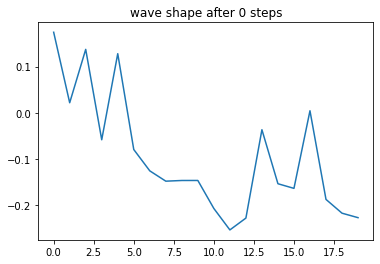

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_0/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_0/model_weights.tf
generator loss:0.43384620019254955
-----------------------
total discriminator loss:0.7378164787653876
average true return:0.6607437140170616
-----------------------


  0%|          | 1/1562 [00:13<5:41:19, 13.12s/it]

Training Step: 1
generator loss:0.4293052315089141
-----------------------
total discriminator loss:0.73710488587806
average true return:0.6598052341997485
-----------------------


  0%|          | 2/1562 [00:15<3:02:48,  7.03s/it]

Training Step: 2
generator loss:0.432798208222332
-----------------------
total discriminator loss:0.7462639038231348
average true return:0.6598509883711161
-----------------------


  0%|          | 3/1562 [00:18<2:10:49,  5.04s/it]

Training Step: 3
generator loss:0.43029021710383264
-----------------------
total discriminator loss:0.7462403289996599
average true return:0.6536244407866111
-----------------------


  0%|          | 4/1562 [00:21<1:47:31,  4.14s/it]

Training Step: 4
generator loss:0.43899303989008454
-----------------------
total discriminator loss:0.7511305291395034
average true return:0.6512330084987447
-----------------------


  0%|          | 5/1562 [00:24<1:34:10,  3.63s/it]

Training Step: 5
event_types: [2, 2, 1, 2, 3, 3, 0, 1, 1, 1, 0, 1, 1, 3, 1, 0, 1, 0, 2, 3]
mad_score: 0.6605625
fid_score: 9397.364040482636
rule_score: 0.513


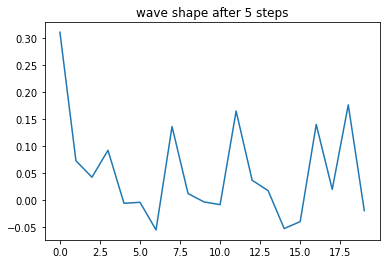

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_5/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_5/model_weights.tf
generator loss:0.4367317192998226
-----------------------
total discriminator loss:0.7417394100554084
average true return:0.6503011810672992
-----------------------


  0%|          | 6/1562 [00:36<2:51:46,  6.62s/it]

Training Step: 6
generator loss:0.4455693024701564
-----------------------
total discriminator loss:0.7414368463905211
average true return:0.6432341176681422
-----------------------


  0%|          | 7/1562 [00:39<2:19:03,  5.37s/it]

Training Step: 7
generator loss:0.43432423095579253
-----------------------
total discriminator loss:0.7442610368954735
average true return:0.6431045199356964
-----------------------


  1%|          | 8/1562 [00:41<1:57:06,  4.52s/it]

Training Step: 8
generator loss:0.4420924538635444
-----------------------
total discriminator loss:0.7568857755827956
average true return:0.6416642904487841
-----------------------


  1%|          | 9/1562 [00:44<1:42:32,  3.96s/it]

Training Step: 9
generator loss:0.44520248180957944
-----------------------
total discriminator loss:0.7533483305386053
average true return:0.6382426173875151
-----------------------


  1%|          | 10/1562 [00:47<1:32:14,  3.57s/it]

Training Step: 10
event_types: [1, 2, 1, 2, 0, 1, 1, 1, 3, 2, 0, 3, 0, 3, 2, 1, 1, 2, 0, 2]
mad_score: 0.7159875
fid_score: 9758.527319578368
rule_score: 0.42475


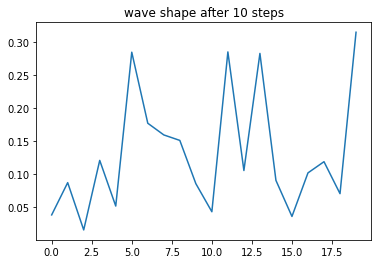

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_10/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_10/model_weights.tf
generator loss:0.4533580874482926
-----------------------
total discriminator loss:0.7138391833938504
average true return:0.6374988301884035
-----------------------


  1%|          | 11/1562 [01:00<2:47:16,  6.47s/it]

Training Step: 11
generator loss:0.4477311375057611
-----------------------
total discriminator loss:0.7552430594552041
average true return:0.6367573302452993
-----------------------


  1%|          | 12/1562 [01:03<2:17:29,  5.32s/it]

Training Step: 12
generator loss:0.44609718467734
-----------------------
total discriminator loss:0.7549533323287008
average true return:0.6314671989755198
-----------------------


  1%|          | 13/1562 [01:05<1:57:43,  4.56s/it]

Training Step: 13
generator loss:0.45349228302763395
-----------------------
total discriminator loss:0.7490019661137195
average true return:0.6308768885769807
-----------------------


  1%|          | 14/1562 [01:08<1:41:47,  3.95s/it]

Training Step: 14
generator loss:0.44688041385731336
-----------------------
total discriminator loss:0.7563910882736178
average true return:0.6287799478860177
-----------------------


  1%|          | 15/1562 [01:11<1:32:27,  3.59s/it]

Training Step: 15
event_types: [1, 2, 3, 2, 1, 2, 1, 2, 1, 2, 0, 0, 2, 3, 3, 0, 2, 0, 1, 0]
mad_score: 0.771625
fid_score: 10762.321309329094
rule_score: 0.3925


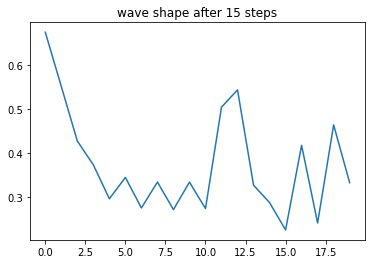

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_15/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_15/model_weights.tf
generator loss:0.45580329220685384
-----------------------
total discriminator loss:0.7571465600990219
average true return:0.6279244698187246
-----------------------


  1%|          | 16/1562 [01:24<2:45:14,  6.41s/it]

Training Step: 16
generator loss:0.45199250942677344
-----------------------
total discriminator loss:0.7487325813585666
average true return:0.6167088600763551
-----------------------


  1%|          | 17/1562 [01:26<2:16:47,  5.31s/it]

Training Step: 17
generator loss:0.4609859978632101
-----------------------
total discriminator loss:0.7602641880616583
average true return:0.623437551669947
-----------------------


  1%|          | 18/1562 [01:29<1:56:47,  4.54s/it]

Training Step: 18
generator loss:0.4613598318541485
-----------------------
total discriminator loss:0.7534083293122549
average true return:0.6205939393059496
-----------------------


  1%|          | 19/1562 [01:32<1:43:45,  4.03s/it]

Training Step: 19
generator loss:0.4565847440574047
-----------------------
total discriminator loss:0.7522077940779996
average true return:0.6127339417385252
-----------------------


  1%|▏         | 20/1562 [01:35<1:33:37,  3.64s/it]

Training Step: 20
event_types: [3, 0, 1, 3, 1, 0, 2, 2, 0, 1, 2, 2, 3, 1, 0, 0, 2, 1, 1, 1]
mad_score: 0.8182875
fid_score: 12386.678308898301
rule_score: 0.36175


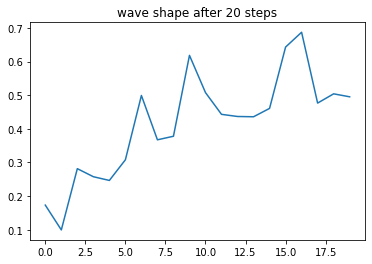

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_20/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_20/model_weights.tf
generator loss:0.4791979030401371
-----------------------
total discriminator loss:0.7485023714043565
average true return:0.6122015303316845
-----------------------


  1%|▏         | 21/1562 [01:47<2:43:32,  6.37s/it]

Training Step: 21
generator loss:0.4680800135086993
-----------------------
total discriminator loss:0.7464050951695389
average true return:0.6138172441207633
-----------------------


  1%|▏         | 22/1562 [01:50<2:15:51,  5.29s/it]

Training Step: 22
generator loss:0.4668057392847818
-----------------------
total discriminator loss:0.7595358329373725
average true return:0.6094389891396077
-----------------------


  1%|▏         | 23/1562 [01:53<1:56:00,  4.52s/it]

Training Step: 23
generator loss:0.46575809771043364
-----------------------
total discriminator loss:0.7390248083254395
average true return:0.6053260055360343
-----------------------


  2%|▏         | 24/1562 [01:56<1:42:06,  3.98s/it]

Training Step: 24
generator loss:0.474026634779967
-----------------------
total discriminator loss:0.7567667906831828
average true return:0.6034790455913978
-----------------------


  2%|▏         | 25/1562 [01:58<1:32:05,  3.59s/it]

Training Step: 25
event_types: [0, 1, 2, 2, 1, 0, 2, 1, 0, 1, 3, 1, 0, 2, 1, 0, 1, 0, 0, 1]
mad_score: 0.8616625
fid_score: 14664.070825477469
rule_score: 0.347


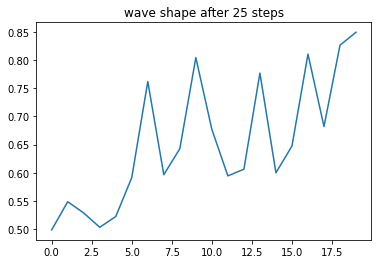

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_25/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_25/model_weights.tf
generator loss:0.47720775561165385
-----------------------
total discriminator loss:0.7577016486441789
average true return:0.6064848502868241
-----------------------


  2%|▏         | 26/1562 [02:11<2:42:52,  6.36s/it]

Training Step: 26
generator loss:0.47632961094355075
-----------------------
total discriminator loss:0.7475798068728665
average true return:0.5991591349225058
-----------------------


  2%|▏         | 27/1562 [02:14<2:13:37,  5.22s/it]

Training Step: 27
generator loss:0.48044822688182104
-----------------------
total discriminator loss:0.7520183297020356
average true return:0.6016678332416214
-----------------------


  2%|▏         | 28/1562 [02:16<1:53:30,  4.44s/it]

Training Step: 28
generator loss:0.48375391273595414
-----------------------
total discriminator loss:0.7515032815430067
average true return:0.6006799481615923
-----------------------


  2%|▏         | 29/1562 [02:19<1:40:18,  3.93s/it]

Training Step: 29
generator loss:0.4851215541495111
-----------------------
total discriminator loss:0.7489302839908395
average true return:0.5974990298051468
-----------------------


  2%|▏         | 30/1562 [02:22<1:30:56,  3.56s/it]

Training Step: 30
event_types: [1, 1, 1, 1, 2, 0, 1, 1, 0, 0, 0, 2, 1, 0, 0, 1, 1, 3, 3, 0]
mad_score: 0.89445
fid_score: 17890.95555519261
rule_score: 0.35775


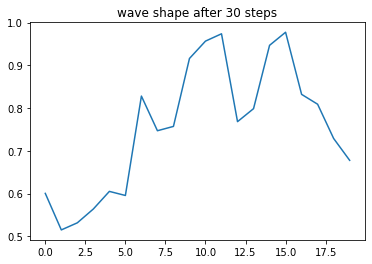

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_30/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_30/model_weights.tf
generator loss:0.48827342910170074
-----------------------
total discriminator loss:0.7581248550052011
average true return:0.5933583357462568
-----------------------


  2%|▏         | 31/1562 [02:35<2:42:52,  6.38s/it]

Training Step: 31
generator loss:0.48787609104434926
-----------------------
total discriminator loss:0.7592355431190758
average true return:0.589090691241281
-----------------------


  2%|▏         | 32/1562 [02:38<2:14:29,  5.27s/it]

Training Step: 32
generator loss:0.48928643502775954
-----------------------
total discriminator loss:0.7622410833814801
average true return:0.5873700702893789
-----------------------


  2%|▏         | 33/1562 [02:40<1:54:58,  4.51s/it]

Training Step: 33
generator loss:0.49503043796010193
-----------------------
total discriminator loss:0.748644917649108
average true return:0.5852582764697645
-----------------------


  2%|▏         | 34/1562 [02:43<1:41:50,  4.00s/it]

Training Step: 34
generator loss:0.49416150094890127
-----------------------
total discriminator loss:0.7444053593011465
average true return:0.5853942659913656
-----------------------


  2%|▏         | 35/1562 [02:46<1:32:06,  3.62s/it]

Training Step: 35
event_types: [2, 0, 1, 1, 3, 1, 0, 0, 1, 2, 2, 2, 0, 0, 1, 1, 0, 3, 0, 0]
mad_score: 0.9157375
fid_score: 22305.62402933975
rule_score: 0.37275


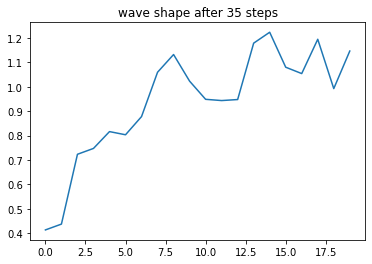

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_35/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_35/model_weights.tf
generator loss:0.5084524006087608
-----------------------
total discriminator loss:0.747779043576374
average true return:0.5840798585702688
-----------------------


  2%|▏         | 36/1562 [02:59<2:41:54,  6.37s/it]

Training Step: 36
generator loss:0.509334521095444
-----------------------
total discriminator loss:0.7475198830940768
average true return:0.5829884480893236
-----------------------


  2%|▏         | 37/1562 [03:01<2:13:59,  5.27s/it]

Training Step: 37
generator loss:0.5071942318384303
-----------------------
total discriminator loss:0.7424183325357527
average true return:0.5810716300502821
-----------------------


  2%|▏         | 38/1562 [03:04<1:54:24,  4.50s/it]

Training Step: 38
generator loss:0.5099411559693632
-----------------------
total discriminator loss:0.7426767969420538
average true return:0.5783005208198184
-----------------------


  2%|▏         | 39/1562 [03:07<1:41:36,  4.00s/it]

Training Step: 39
generator loss:0.5122848862314339
-----------------------
total discriminator loss:0.7399446494617322
average true return:0.5744341082651045
-----------------------


  3%|▎         | 40/1562 [03:10<1:31:52,  3.62s/it]

Training Step: 40
event_types: [0, 0, 2, 1, 1, 0, 3, 0, 1, 0, 1, 2, 1, 0, 0, 0, 1, 1, 0, 0]
mad_score: 0.9340875
fid_score: 28144.71594152314
rule_score: 0.379


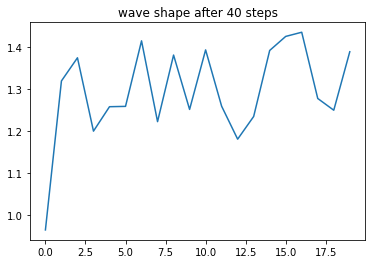

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_40/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_40/model_weights.tf
generator loss:0.517457001186694
-----------------------
total discriminator loss:0.7529427667264837
average true return:0.5705117616537201
-----------------------


  3%|▎         | 41/1562 [03:22<2:40:35,  6.33s/it]

Training Step: 41
generator loss:0.5218797256183119
-----------------------
total discriminator loss:0.7363354255960618
average true return:0.5721576284349528
-----------------------


  3%|▎         | 42/1562 [03:25<2:13:36,  5.27s/it]

Training Step: 42
generator loss:0.5242423070098257
-----------------------
total discriminator loss:0.749892045331847
average true return:0.5660289981632098
-----------------------


  3%|▎         | 43/1562 [03:28<1:54:16,  4.51s/it]

Training Step: 43
generator loss:0.5302472872188693
-----------------------
total discriminator loss:0.7490791480842847
average true return:0.5674231718654744
-----------------------


  3%|▎         | 44/1562 [03:30<1:40:30,  3.97s/it]

Training Step: 44
generator loss:0.5354298781882855
-----------------------
total discriminator loss:0.7404819095921957
average true return:0.5683896039769418
-----------------------


  3%|▎         | 45/1562 [03:33<1:31:38,  3.62s/it]

Training Step: 45
event_types: [0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0]
mad_score: 0.9448875
fid_score: 35678.87321553356
rule_score: 0.40975


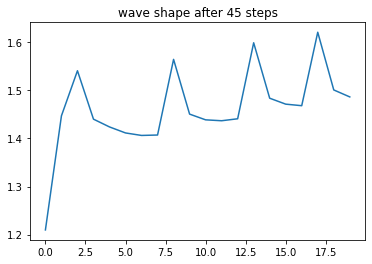

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_45/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_45/model_weights.tf
generator loss:0.5376355969825586
-----------------------
total discriminator loss:0.7334554536112412
average true return:0.5667391426928572
-----------------------


  3%|▎         | 46/1562 [03:46<2:43:02,  6.45s/it]

Training Step: 46
generator loss:0.5401926131852022
-----------------------
total discriminator loss:0.6734419403254797
average true return:0.5643417017175603
-----------------------


  3%|▎         | 47/1562 [03:49<2:14:52,  5.34s/it]

Training Step: 47
generator loss:0.5415611767909473
-----------------------
total discriminator loss:0.7378078790183598
average true return:0.5619766843647682
-----------------------


  3%|▎         | 48/1562 [03:52<1:55:15,  4.57s/it]

Training Step: 48
generator loss:0.549048334840331
-----------------------
total discriminator loss:0.7361406423950927
average true return:0.559091222515001
-----------------------


  3%|▎         | 49/1562 [03:54<1:40:10,  3.97s/it]

Training Step: 49
generator loss:0.5462242869439872
-----------------------
total discriminator loss:0.7399567894193213
average true return:0.557691869102824
-----------------------


  3%|▎         | 50/1562 [03:57<1:29:28,  3.55s/it]

Training Step: 50
event_types: [0, 2, 1, 1, 1, 2, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 2, 1, 1]
mad_score: 0.953275
fid_score: 45017.555536664746
rule_score: 0.4175


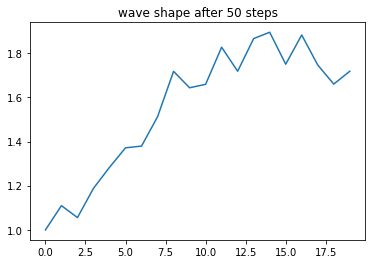

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_50/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_50/model_weights.tf
generator loss:0.5542902803098454
-----------------------
total discriminator loss:0.7388395062552353
average true return:0.5552255163453894
-----------------------


  3%|▎         | 51/1562 [04:10<2:40:29,  6.37s/it]

Training Step: 51
generator loss:0.5574137753682705
-----------------------
total discriminator loss:0.7329548969284072
average true return:0.5528069598736447
-----------------------


  3%|▎         | 52/1562 [04:13<2:12:38,  5.27s/it]

Training Step: 52
generator loss:0.5598353349561633
-----------------------
total discriminator loss:0.671572159868488
average true return:0.5510421820457566
-----------------------


  3%|▎         | 53/1562 [04:15<1:53:29,  4.51s/it]

Training Step: 53
generator loss:0.5598836230557707
-----------------------
total discriminator loss:0.7282751601306826
average true return:0.5500683282441798
-----------------------


  3%|▎         | 54/1562 [04:18<1:40:27,  4.00s/it]

Training Step: 54
generator loss:0.5638693301499991
-----------------------
total discriminator loss:0.7322723785114682
average true return:0.5477035624913431
-----------------------


  4%|▎         | 55/1562 [04:21<1:30:39,  3.61s/it]

Training Step: 55
event_types: [1, 2, 1, 2, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 3, 0, 1, 3, 0, 1]
mad_score: 0.9601375
fid_score: 56255.392195146596
rule_score: 0.41725


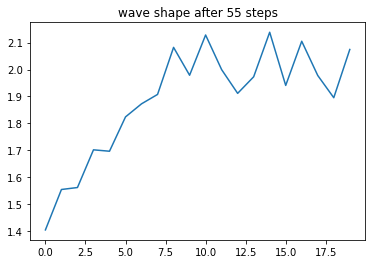

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_55/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_55/model_weights.tf
generator loss:0.5726680769721402
-----------------------
total discriminator loss:0.730253378884942
average true return:0.5488274451505767
-----------------------


  4%|▎         | 56/1562 [04:33<2:37:40,  6.28s/it]

Training Step: 56
generator loss:0.5713647162917667
-----------------------
total discriminator loss:0.7369541271608631
average true return:0.5455363451733047
-----------------------


  4%|▎         | 57/1562 [04:36<2:06:56,  5.06s/it]

Training Step: 57
generator loss:0.573959363993718
-----------------------
total discriminator loss:0.7271134039347894
average true return:0.5466307600772117
-----------------------


  4%|▎         | 58/1562 [04:38<1:45:12,  4.20s/it]

Training Step: 58
generator loss:0.5775336600267936
-----------------------
total discriminator loss:0.727385861433566
average true return:0.5431095661158816
-----------------------


  4%|▍         | 59/1562 [04:40<1:30:08,  3.60s/it]

Training Step: 59
generator loss:0.5812796780574578
-----------------------
total discriminator loss:0.7323555349084352
average true return:0.5400129845356554
-----------------------


  4%|▍         | 60/1562 [04:42<1:19:03,  3.16s/it]

Training Step: 60
event_types: [0, 0, 1, 0, 3, 1, 0, 1, 2, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0]
mad_score: 0.963025
fid_score: 69702.67042386883
rule_score: 0.41175


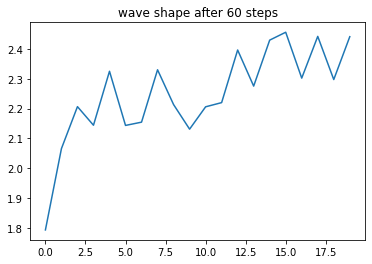

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_60/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_60/model_weights.tf
generator loss:0.5877861632838925
-----------------------
total discriminator loss:0.7304862274769213
average true return:0.54005788844066
-----------------------


  4%|▍         | 61/1562 [04:52<2:10:01,  5.20s/it]

Training Step: 61
generator loss:0.5850951342861398
-----------------------
total discriminator loss:0.7243338692832333
average true return:0.5404307914811464
-----------------------


  4%|▍         | 62/1562 [04:54<1:47:42,  4.31s/it]

Training Step: 62
generator loss:0.5914294253407205
-----------------------
total discriminator loss:0.7198751447580493
average true return:0.538135582087785
-----------------------


  4%|▍         | 63/1562 [04:56<1:31:35,  3.67s/it]

Training Step: 63
generator loss:0.5949038773199702
-----------------------
total discriminator loss:0.7224377886736966
average true return:0.5367855531680328
-----------------------


  4%|▍         | 64/1562 [04:59<1:20:07,  3.21s/it]

Training Step: 64
generator loss:0.5962919365276975
-----------------------
total discriminator loss:0.7229248601088922
average true return:0.5326075231996552
-----------------------


  4%|▍         | 65/1562 [05:01<1:12:34,  2.91s/it]

Training Step: 65
event_types: [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1]
mad_score: 0.9662375
fid_score: 85102.11829818736
rule_score: 0.3675


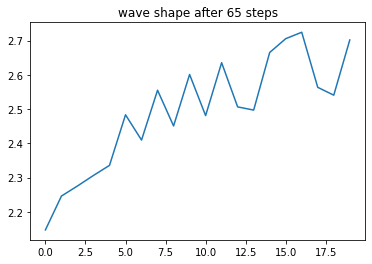

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_65/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_65/model_weights.tf
generator loss:0.5999568661933936
-----------------------
total discriminator loss:0.7283209020880672
average true return:0.5319449844281638
-----------------------


  4%|▍         | 66/1562 [05:11<2:05:11,  5.02s/it]

Training Step: 66
generator loss:0.6072598855829345
-----------------------
total discriminator loss:0.7252654883789145
average true return:0.5301718521840191
-----------------------


  4%|▍         | 67/1562 [05:13<1:43:31,  4.15s/it]

Training Step: 67
generator loss:0.6090266335131722
-----------------------
total discriminator loss:0.7240492738157397
average true return:0.5276684136634964
-----------------------


  4%|▍         | 68/1562 [05:15<1:28:59,  3.57s/it]

Training Step: 68
generator loss:0.6126491831722649
-----------------------
total discriminator loss:0.721387875881693
average true return:0.5289163823090486
-----------------------


  4%|▍         | 69/1562 [05:17<1:18:09,  3.14s/it]

Training Step: 69
generator loss:0.6128124009552094
-----------------------
total discriminator loss:0.7173015459179881
average true return:0.5247731569227359
-----------------------


  4%|▍         | 70/1562 [05:19<1:10:34,  2.84s/it]

Training Step: 70
event_types: [1, 1, 2, 1, 0, 0, 0, 1, 0, 1, 2, 0, 1, 0, 2, 2, 0, 1, 0, 1]
mad_score: 0.9678
fid_score: 102528.26363649048
rule_score: 0.3325


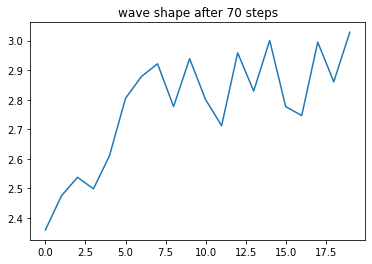

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_70/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_70/model_weights.tf
generator loss:0.6170279355681255
-----------------------
total discriminator loss:0.7191559428313056
average true return:0.5241496879363572
-----------------------


  5%|▍         | 71/1562 [05:29<2:03:25,  4.97s/it]

Training Step: 71
generator loss:0.622823686732364
-----------------------
total discriminator loss:0.7182811969614644
average true return:0.5220911163933064
-----------------------


  5%|▍         | 72/1562 [05:31<1:42:08,  4.11s/it]

Training Step: 72
generator loss:0.6255822294651417
-----------------------
total discriminator loss:0.7194719953994803
average true return:0.5225015578123913
-----------------------


  5%|▍         | 73/1562 [05:34<1:27:22,  3.52s/it]

Training Step: 73
generator loss:0.6282203134018416
-----------------------
total discriminator loss:0.7124009553908319
average true return:0.5225246160747021
-----------------------


  5%|▍         | 74/1562 [05:36<1:17:33,  3.13s/it]

Training Step: 74
generator loss:0.6327054374787915
-----------------------
total discriminator loss:0.7093395972261067
average true return:0.5227943566987874
-----------------------


  5%|▍         | 75/1562 [05:38<1:10:05,  2.83s/it]

Training Step: 75
event_types: [1, 0, 1, 1, 0, 1, 1, 0, 1, 3, 1, 0, 1, 0, 0, 0, 1, 1, 2, 0]
mad_score: 0.9697125
fid_score: 121723.0235917992
rule_score: 0.2565


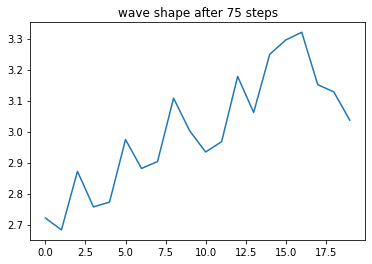

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_75/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_75/model_weights.tf
generator loss:0.6394555443260947
-----------------------
total discriminator loss:0.7112028718389551
average true return:0.5195410422351967
-----------------------


  5%|▍         | 76/1562 [05:48<2:02:55,  4.96s/it]

Training Step: 76
generator loss:0.6369501198147424
-----------------------
total discriminator loss:0.7177397896997341
average true return:0.5160186362764827
-----------------------


  5%|▍         | 77/1562 [05:50<1:41:48,  4.11s/it]

Training Step: 77
generator loss:0.640729010147534
-----------------------
total discriminator loss:0.7130530254519533
average true return:0.517059427441964
-----------------------


  5%|▍         | 78/1562 [05:52<1:27:00,  3.52s/it]

Training Step: 78
generator loss:0.6455164840773273
-----------------------
total discriminator loss:0.710548320076683
average true return:0.5134332944809301
-----------------------


  5%|▌         | 79/1562 [05:54<1:17:14,  3.13s/it]

Training Step: 79
generator loss:0.6457225772494877
-----------------------
total discriminator loss:0.7176449079991916
average true return:0.5107145558631248
-----------------------


  5%|▌         | 80/1562 [05:56<1:09:44,  2.82s/it]

Training Step: 80
event_types: [1, 1, 0, 1, 0, 0, 0, 3, 2, 0, 1, 0, 0, 1, 0, 0, 3, 1, 0, 0]
mad_score: 0.9704875
fid_score: 142208.27717946316
rule_score: 0.172


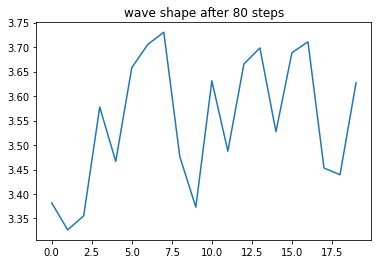

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_80/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_80/model_weights.tf
generator loss:0.6521187671743719
-----------------------
total discriminator loss:0.7060308368365178
average true return:0.5110608534670414
-----------------------


  5%|▌         | 81/1562 [06:06<2:02:03,  4.95s/it]

Training Step: 81
generator loss:0.6532306394927379
-----------------------
total discriminator loss:0.7131680680192541
average true return:0.5080516458932757
-----------------------


  5%|▌         | 82/1562 [06:09<1:45:43,  4.29s/it]

Training Step: 82
generator loss:0.657404313184067
-----------------------
total discriminator loss:0.7100351225182722
average true return:0.5082801401357991
-----------------------


  5%|▌         | 83/1562 [06:12<1:34:03,  3.82s/it]

Training Step: 83
generator loss:0.6624404267898997
-----------------------
total discriminator loss:0.7047239306814188
average true return:0.5122771369445074
-----------------------


  5%|▌         | 84/1562 [06:15<1:25:43,  3.48s/it]

Training Step: 84
generator loss:0.6612047662012736
-----------------------
total discriminator loss:0.7074185042254959
average true return:0.5073107775198062
-----------------------


  5%|▌         | 85/1562 [06:17<1:20:33,  3.27s/it]

Training Step: 85
event_types: [1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 2, 3, 1, 3, 0, 1, 1]
mad_score: 0.96705
fid_score: 163654.43684144033
rule_score: 0.0945


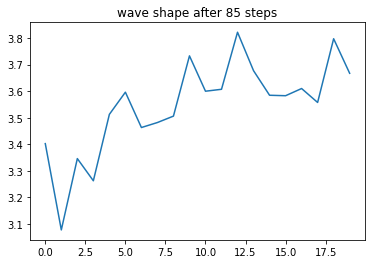

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_85/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_85/model_weights.tf
generator loss:0.6705511063394681
-----------------------
total discriminator loss:0.7056064143706751
average true return:0.5045166193645932
-----------------------


  6%|▌         | 86/1562 [06:29<2:18:59,  5.65s/it]

Training Step: 86
generator loss:0.6682147874049662
-----------------------
total discriminator loss:0.7009498345093361
average true return:0.5058242981906431
-----------------------


  6%|▌         | 87/1562 [06:31<1:52:55,  4.59s/it]

Training Step: 87
generator loss:0.6724033797807967
-----------------------
total discriminator loss:0.6996373280465773
average true return:0.5068327828088885
-----------------------


  6%|▌         | 88/1562 [06:33<1:35:17,  3.88s/it]

Training Step: 88
generator loss:0.6717815782339773
-----------------------
total discriminator loss:0.6998444161750593
average true return:0.5074193366361804
-----------------------


  6%|▌         | 89/1562 [06:35<1:22:36,  3.36s/it]

Training Step: 89
generator loss:0.6732443044068831
-----------------------
total discriminator loss:0.6912844598775676
average true return:0.5052581950391608
-----------------------


  6%|▌         | 90/1562 [06:37<1:13:27,  2.99s/it]

Training Step: 90
event_types: [0, 1, 1, 0, 3, 1, 0, 3, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 3, 1]
mad_score: 0.9666875
fid_score: 183989.0709347216
rule_score: 0.02275


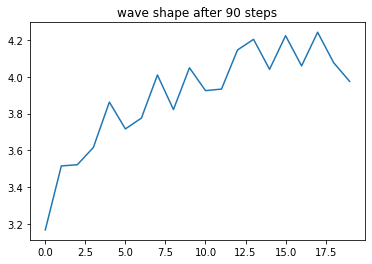

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_90/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_90/model_weights.tf
generator loss:0.6767082004194771
-----------------------
total discriminator loss:0.7038116699737476
average true return:0.5030967210021704
-----------------------


  6%|▌         | 91/1562 [06:47<2:04:01,  5.06s/it]

Training Step: 91
generator loss:0.681561476056934
-----------------------
total discriminator loss:0.6847786638882057
average true return:0.5039094227144041
-----------------------


  6%|▌         | 92/1562 [06:49<1:42:23,  4.18s/it]

Training Step: 92
generator loss:0.6766166389213867
-----------------------
total discriminator loss:0.7026018824100615
average true return:0.50277923093684
-----------------------


  6%|▌         | 93/1562 [06:51<1:27:16,  3.56s/it]

Training Step: 93
generator loss:0.6735052868473247
-----------------------
total discriminator loss:0.7043766930919686
average true return:0.503920335305383
-----------------------


  6%|▌         | 94/1562 [06:53<1:16:41,  3.13s/it]

Training Step: 94
generator loss:0.6746503668326447
-----------------------
total discriminator loss:0.7041576702700006
average true return:0.5033616521496819
-----------------------


  6%|▌         | 95/1562 [06:56<1:09:15,  2.83s/it]

Training Step: 95
event_types: [0, 1, 1, 0, 1, 0, 0, 0, 1, 3, 1, 3, 3, 0, 1, 1, 0, 0, 1, 1]
mad_score: 0.965775
fid_score: 202719.47717622606
rule_score: 0.00225


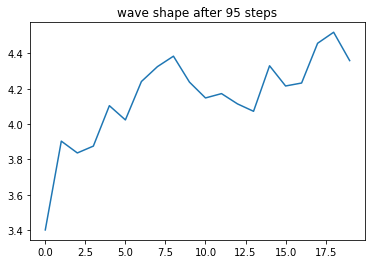

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_95/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_95/model_weights.tf
generator loss:0.6717837162001392
-----------------------
total discriminator loss:0.7100306891520889
average true return:0.50517704086768
-----------------------


  6%|▌         | 96/1562 [07:07<2:14:41,  5.51s/it]

Training Step: 96
generator loss:0.6679101117894355
-----------------------
total discriminator loss:0.7048385033784645
average true return:0.5050154968015412
-----------------------


  6%|▌         | 97/1562 [07:09<1:49:49,  4.50s/it]

Training Step: 97
generator loss:0.6695815445161009
-----------------------
total discriminator loss:0.7066944272171993
average true return:0.5075369120163528
-----------------------


  6%|▋         | 98/1562 [07:12<1:33:13,  3.82s/it]

Training Step: 98
generator loss:0.6612072774722371
-----------------------
total discriminator loss:0.7106197075509599
average true return:0.5092400813618656
-----------------------


  6%|▋         | 99/1562 [07:14<1:24:55,  3.48s/it]

Training Step: 99
generator loss:0.6589355952467006
-----------------------
total discriminator loss:0.718869573044382
average true return:0.5055213328656272
-----------------------


  6%|▋         | 100/1562 [07:17<1:18:26,  3.22s/it]

Training Step: 100
event_types: [3, 0, 0, 0, 3, 1, 0, 3, 1, 1, 0, 1, 1, 0, 3, 0, 1, 1, 3, 0]
mad_score: 0.96545
fid_score: 218435.7291963811
rule_score: 0.0


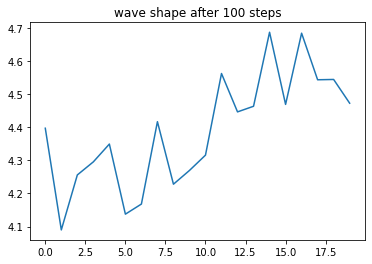

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_100/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_100/model_weights.tf
generator loss:0.65414868950255
-----------------------
total discriminator loss:0.7161478296988553
average true return:0.5092237430179123
-----------------------


  6%|▋         | 101/1562 [07:27<2:07:40,  5.24s/it]

Training Step: 101
generator loss:0.6504806655198063
-----------------------
total discriminator loss:0.7134659644865996
average true return:0.5116462578988024
-----------------------


  7%|▋         | 102/1562 [07:29<1:45:28,  4.33s/it]

Training Step: 102
generator loss:0.6496087341285453
-----------------------
total discriminator loss:0.7162009064656967
average true return:0.5116744375086435
-----------------------


  7%|▋         | 103/1562 [07:31<1:29:17,  3.67s/it]

Training Step: 103
generator loss:0.647690339603617
-----------------------
total discriminator loss:0.7181592005709571
average true return:0.5126563259656868
-----------------------


  7%|▋         | 104/1562 [07:33<1:18:03,  3.21s/it]

Training Step: 104
generator loss:0.6422478464846099
-----------------------
total discriminator loss:0.7161688563316225
average true return:0.5161596199013045
-----------------------


  7%|▋         | 105/1562 [07:36<1:10:43,  2.91s/it]

Training Step: 105
event_types: [3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 1, 3, 0, 3, 0, 1]
mad_score: 0.967625
fid_score: 231505.5497877216
rule_score: 0.0


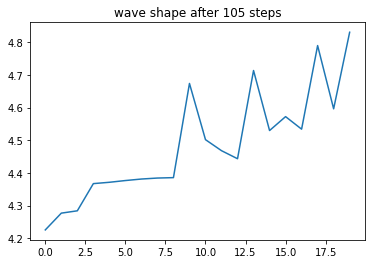

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_105/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_105/model_weights.tf
generator loss:0.6377632908935369
-----------------------
total discriminator loss:0.726406486221494
average true return:0.5153150309214585
-----------------------


  7%|▋         | 106/1562 [07:45<2:00:47,  4.98s/it]

Training Step: 106
generator loss:0.6337833432686315
-----------------------
total discriminator loss:0.7220066732680401
average true return:0.5154713115973109
-----------------------


  7%|▋         | 107/1562 [07:48<1:40:13,  4.13s/it]

Training Step: 107
generator loss:0.6379005776730571
-----------------------
total discriminator loss:0.725081318083254
average true return:0.5179380834170455
-----------------------


  7%|▋         | 108/1562 [07:50<1:26:16,  3.56s/it]

Training Step: 108
generator loss:0.6310110878179508
-----------------------
total discriminator loss:0.7314822164215176
average true return:0.5141686881808096
-----------------------


  7%|▋         | 109/1562 [07:52<1:15:48,  3.13s/it]

Training Step: 109
generator loss:0.6316836659130286
-----------------------
total discriminator loss:0.7245194703992732
average true return:0.5168545934724662
-----------------------


  7%|▋         | 110/1562 [07:54<1:08:29,  2.83s/it]

Training Step: 110
event_types: [3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 0, 3, 3, 3, 3, 3, 1, 3, 0]
mad_score: 0.9718875
fid_score: 245090.47589539754
rule_score: 0.0


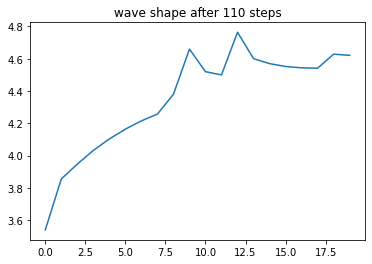

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_110/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_110/model_weights.tf
generator loss:0.6351616246625502
-----------------------
total discriminator loss:0.7238497930007801
average true return:0.5196351590074098
-----------------------


  7%|▋         | 111/1562 [08:04<1:59:59,  4.96s/it]

Training Step: 111
generator loss:0.6311660042984557
-----------------------
total discriminator loss:0.7273098001651627
average true return:0.5167500560854403
-----------------------


  7%|▋         | 112/1562 [08:06<1:39:20,  4.11s/it]

Training Step: 112
generator loss:0.6358959582377545
-----------------------
total discriminator loss:0.7265331830199906
average true return:0.5162126356614203
-----------------------


  7%|▋         | 113/1562 [08:08<1:24:55,  3.52s/it]

Training Step: 113
generator loss:0.6387151807941447
-----------------------
total discriminator loss:0.724157062269299
average true return:0.514740298373559
-----------------------


  7%|▋         | 114/1562 [08:10<1:15:18,  3.12s/it]

Training Step: 114
generator loss:0.6440375170218253
-----------------------
total discriminator loss:0.7241645925893883
average true return:0.5131931653465848
-----------------------


  7%|▋         | 115/1562 [08:13<1:08:08,  2.83s/it]

Training Step: 115
event_types: [3, 3, 1, 0, 3, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3]
mad_score: 0.97485
fid_score: 261748.79183068432
rule_score: 0.0


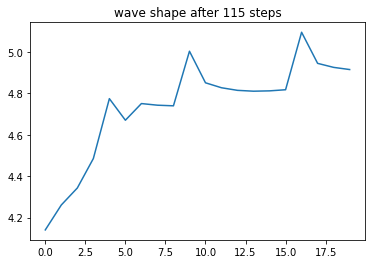

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_115/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_115/model_weights.tf
generator loss:0.6504027976741895
-----------------------
total discriminator loss:0.722059712079636
average true return:0.5085410250764208
-----------------------


  7%|▋         | 116/1562 [08:22<1:58:51,  4.93s/it]

Training Step: 116
generator loss:0.6541367202612562
-----------------------
total discriminator loss:0.7173310501604448
average true return:0.5086246764716432
-----------------------


  7%|▋         | 117/1562 [08:25<1:38:30,  4.09s/it]

Training Step: 117
generator loss:0.6629695714518813
-----------------------
total discriminator loss:0.7117088116949958
average true return:0.5055118201208356
-----------------------


  8%|▊         | 118/1562 [08:27<1:24:17,  3.50s/it]

Training Step: 118
generator loss:0.6722153598407918
-----------------------
total discriminator loss:0.708318529934627
average true return:0.5043735960209075
-----------------------


  8%|▊         | 119/1562 [08:29<1:14:55,  3.12s/it]

Training Step: 119
generator loss:0.6793633620363777
-----------------------
total discriminator loss:0.7048395070246575
average true return:0.5009601601799929
-----------------------


  8%|▊         | 120/1562 [08:31<1:08:16,  2.84s/it]

Training Step: 120
event_types: [3, 3, 3, 3, 3, 1, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
mad_score: 0.9797875
fid_score: 283236.6113894869
rule_score: 0.0


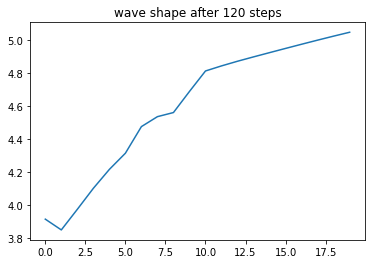

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_120/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_120/model_weights.tf
generator loss:0.6894654508907142
-----------------------
total discriminator loss:0.6978983225079892
average true return:0.4981786237524565
-----------------------


  8%|▊         | 121/1562 [08:41<1:58:11,  4.92s/it]

Training Step: 121
generator loss:0.7021901366812209
-----------------------
total discriminator loss:0.7000760712110647
average true return:0.49067920913459817
-----------------------


  8%|▊         | 122/1562 [08:43<1:38:37,  4.11s/it]

Training Step: 122
generator loss:0.7137988214205487
-----------------------
total discriminator loss:0.6936142315120993
average true return:0.4895174331979571
-----------------------


  8%|▊         | 123/1562 [08:45<1:24:16,  3.51s/it]

Training Step: 123
generator loss:0.7267503990239369
-----------------------
total discriminator loss:0.6870079078611241
average true return:0.48666487390639934
-----------------------


  8%|▊         | 124/1562 [08:47<1:14:12,  3.10s/it]

Training Step: 124
generator loss:0.7382438601545658
-----------------------
total discriminator loss:0.6796619388476941
average true return:0.48229845620559664
-----------------------


  8%|▊         | 125/1562 [08:50<1:07:48,  2.83s/it]

Training Step: 125
event_types: [2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3]
mad_score: 0.98075
fid_score: 309579.8076102283
rule_score: 0.0


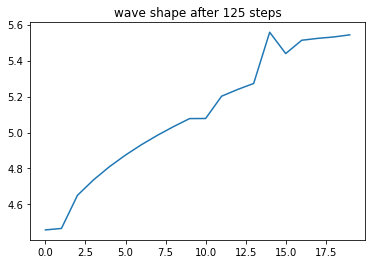

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_125/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_125/model_weights.tf
generator loss:0.7526801814119659
-----------------------
total discriminator loss:0.6742964006713417
average true return:0.47745684917411535
-----------------------


  8%|▊         | 126/1562 [08:59<1:57:28,  4.91s/it]

Training Step: 126
generator loss:0.7682856730056336
-----------------------
total discriminator loss:0.67100651712549
average true return:0.47309925569784395
-----------------------


  8%|▊         | 127/1562 [09:01<1:37:25,  4.07s/it]

Training Step: 127
generator loss:0.7840958711780417
-----------------------
total discriminator loss:0.6653847015556669
average true return:0.46892069599095976
-----------------------


  8%|▊         | 128/1562 [09:04<1:23:59,  3.51s/it]

Training Step: 128
generator loss:0.8013882187733679
-----------------------
total discriminator loss:0.6568989178923632
average true return:0.46253692091088616
-----------------------


  8%|▊         | 129/1562 [09:06<1:14:01,  3.10s/it]

Training Step: 129
generator loss:0.8135037109533733
-----------------------
total discriminator loss:0.6552845586717352
average true return:0.45778075062806234
-----------------------


  8%|▊         | 130/1562 [09:08<1:06:59,  2.81s/it]

Training Step: 130
event_types: [3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
mad_score: 0.9801
fid_score: 335026.42971103
rule_score: 0.0


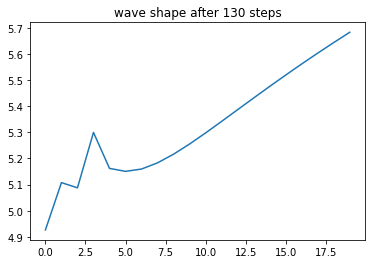

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/G_130/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-04-02-05-38-01/D_130/model_weights.tf
generator loss:0.8353796840564429
-----------------------
total discriminator loss:0.6483663286675364
average true return:0.4533537186736262
-----------------------


  8%|▊         | 131/1562 [09:18<1:57:37,  4.93s/it]

Training Step: 131
generator loss:0.8538641858933527
-----------------------
total discriminator loss:0.6465671253093092
average true return:0.44676958215520834
-----------------------


  8%|▊         | 132/1562 [09:20<1:37:30,  4.09s/it]

Training Step: 132
generator loss:0.8713371180283775
-----------------------
total discriminator loss:0.6313871842426344
average true return:0.44529114055528035
-----------------------


  9%|▊         | 133/1562 [09:22<1:23:23,  3.50s/it]

Training Step: 133
generator loss:0.8930417715901529
-----------------------
total discriminator loss:0.6303204101586929
average true return:0.4387555585017024
-----------------------


  9%|▊         | 134/1562 [09:24<1:14:05,  3.11s/it]

Training Step: 134
generator loss:0.9149214743896805
-----------------------
total discriminator loss:0.6201064400366678
average true return:0.4336234684097924
-----------------------


  9%|▊         | 135/1562 [09:26<1:07:01,  2.82s/it]

Training Step: 135


  9%|▊         | 135/1562 [09:32<1:40:51,  4.24s/it]


KeyboardInterrupt: 

In [175]:
for feature_batch, _ in tqdm(train_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    print('Training Step:', step)
    
    if step % 5 == 0:
        _mad_score, _fid_score, _rule_score = track_training(step, G, model_save_path, verbose=True, plot=True)
        mad_history.append(_mad_score)
        fid_history.append(_fid_score)
        rule_history.append(_rule_score)
        
    # train the generator
    for _ in range(_G_STEPS):
        gen_loss = train_generator_gumbel(G, D, BATCH_SIZE, T, verbose=True, optimizer=G_optimizer)
        gen_loss_history.append(gen_loss.numpy())
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_loss, ave_true_return = train_discriminator_gumbel(event_type_batch, time_delta_batch, G, D, BATCH_SIZE, T,
                                                                verbose=True, optimizer=D_optimizer, 
                                                                label_smoothing=True, label_flipping=True)
        disc_loss_history.append(disc_loss.numpy())
        average_true_return_history.append(ave_true_return.numpy())
                
    step += 1

In [ ]:
x = range(len(gen_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_loss_history)
plt.title('Generator Loss History')
plt.xlabel('Training steps')

x = range(len(disc_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_loss_history)
plt.title('Discriminator Loss History')
plt.xlabel('Training steps')

In [ ]:
x =  [i * 5 for i in range(len(mad_history))]
plt.figure(dpi=100)
plt.plot(x, mad_history)
plt.title('MAD score History')
plt.xlabel('Training steps')

x =  [i * 5 for i in range(len(fid_history))]
plt.figure(dpi=100)
plt.plot(x, fid_history)
plt.title('Fid score History')
plt.xlabel('Training steps')
plt.ylim([0, 30000])

x =  [i * 5 for i in range(len(rule_history))]
plt.figure(dpi=100)
plt.plot(x, rule_history)
plt.title('Oracle score History')
plt.xlabel('Training steps')

## Compare between G0, G1 and G2

In [ ]:
from matplotlib import pyplot as plt

def get_generation_metrics(G):
    _gen_seqs_et, _gen_seqs_ts = generate_sequences_gumbel(N_DATA, G, BATCH_SIZE, T)

    # convert one-hot event types to indices; convert normalized timestamps to original
    _gen_seqs_et_ind = tf.argmax(_gen_seqs_et, axis=2).numpy().reshape(N_DATA, T, 1)
    _gen_seqs_ts_ori = apply_mean_std(_gen_seqs_ts, GLOBAL_MEAN, GLOBAL_STD)
    _gen_seqs_for_rules = np.dstack((_gen_seqs_et_ind, _gen_seqs_ts_ori))    

    _mad_score = calculate_MAD_score(_gen_seqs_et_ind)
    _smad_score = calculate_self_MAD_score(_gen_seqs_et_ind)
    _fid_score = calculate_FID_score(_gen_seqs_ts_ori)
    _rule_score = calculate_rule_score(_gen_seqs_for_rules)
    
    return {'mad' : _mad_score, 'fid' : _fid_score, 'oracle' : _rule_score, 'smad' : _smad_score}

In [ ]:
G0 = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

res0 = get_generation_metrics(G0)

In [ ]:
G1 = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)
G1_save_path = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_0/model_weights.tf'
G1.build(input_shape=((BATCH_SIZE, T, 1)))
G1.load_weights(G1_save_path)

res1 = get_generation_metrics(G1)

In [ ]:
G2 = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)
G2_save_path = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_400/model_weights.tf'
G2.build(input_shape=((BATCH_SIZE, T, 1)))
G2.load_weights(G2_save_path)

res2 = get_generation_metrics(G2)

In [ ]:
res = [res0, res1, res2]

df = pd.DataFrame(res)
df.index = pd.Index(['INIT', 'MLE', 'GAN'])
df

## Generate Synthesized data

In [ ]:
repo_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"
save_path = os.path.join(repo_path, 'syn_data', 'gumbel_softmax_2021-03-30-09-39-43', 'G2')

In [ ]:
def generate_sequence_for_saving(generator, N, save_path):
    _gen_seqs_et, _gen_seqs_ts = generate_sequences_gumbel(N, generator, BATCH_SIZE, T)
    # convert one-hot event types to indices; convert normalized timestamps to original
    _save_seqs_et_ind = tf.argmax(_gen_seqs_et, axis=2).numpy().reshape(N, T, 1)
    _save_seqs_ts_ori = apply_mean_std(_gen_seqs_ts, GLOBAL_MEAN, GLOBAL_STD).numpy().reshape(N, T, 1)
    
    seqs_filename_et = 'syn_type_sequences.pickle'
    seqs_filename_ts = 'syn_time_sequences.pickle'
    
    with open(os.path.join(save_path, seqs_filename_et), 'wb') as f:
        pickle.dump(_save_seqs_et_ind, f)

    with open(os.path.join(save_path, seqs_filename_ts), 'wb') as f:
        pickle.dump(_save_seqs_ts_ori, f)

In [ ]:
save_path_G0 = os.path.join(repo_path, 'syn_data', 'gumbel_softmax_2021-03-30-09-39-43', 'G0')
generate_sequence_for_saving(G0, 400000, save_path_G0)

In [ ]:
save_path_G1 = os.path.join(repo_path, 'syn_data', 'gumbel_softmax_2021-03-30-09-39-43', 'G1')
generate_sequence_for_saving(G1, 400000, save_path_G1)

In [ ]:
_gen_seqs_et, _gen_seqs_ts = generate_sequences_gumbel(400000, G2, BATCH_SIZE, T)

In [ ]:
# convert one-hot event types to indices; convert normalized timestamps to original
_save_seqs_et_ind = tf.argmax(_gen_seqs_et, axis=2).numpy().reshape(400000, T, 1)
_save_seqs_ts_ori = apply_mean_std(_gen_seqs_ts, GLOBAL_MEAN, GLOBAL_STD).numpy().reshape(400000, T, 1)

In [ ]:
pos_seqs_filename_et = 'syn_type_sequences.pickle'
pos_seqs_filename_ts = 'syn_time_sequences.pickle'


with open(os.path.join(save_path, pos_seqs_filename_et), 'wb') as f:
    pickle.dump(_save_seqs_et_ind, f)
    
with open(os.path.join(save_path, pos_seqs_filename_ts), 'wb') as f:
    pickle.dump(_save_seqs_ts_ori, f)

In [ ]:
tf.random.normal((2,1),mean=0, stddev=1)

In [ ]:
save_path